In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import ns
import ns_hdf5
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/halo_NSWD/plots/'

2.1.2


In [2]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allpaths.dat',
                         dtype=str)
model_label = sourcedir[:,0]; paths = sourcedir[:,1]
#model_label = ['Fiducial', 'TDE0.2', 'TDE0.8', 'WDTC', 'TDE0.2-WDTC', 'TDE0.2-WDTC-GCTC', 'WDTC_NSM', 'Alloff_WM']
snap_h5 = 'initial.snapshots.h5'
ab_cut = 8

In [44]:
##Observed name and offsets
psrnames = ['PSRA','PSRB','PSRC','PSRD','PSRE','PSRF']
psroffsets = np.array([6.39, 0.1, 2.7, 0.19, 0.13, 0.082])*60. ##arcsec

psrnames_47Tuc = ['J0023-7204C','J0024-7204D','J0024-7205E','J0024-7204F','J0024-7204G','J0024-7204H',
                  'J0024-7204I','J0023-7203J','J0024-7204L','J0023-7205M','J0024-7204N','J0024-7204O',
                  'J0024-7204Q','J0024-7204R','J0024-7204S','J0024-7204T','J0024-7203U',
                  'J0024-7204W','J0024-7201X','J0024-7204Y','J0024-7204Z','J0024-7204aa',
                  'J0024-7204ab']
psroffsets_47Tuc = np.array([1.21,0.68,0.65,0.19,0.29,0.77,0.29,1,0.14,1.05,0.49,0.06,
                       0.98,0.15,0.19,0.34,0.94,0.08,3.83,0.37,0.15,0.47,0.2])*60. ##arcsec

11054.52569672
476
11247.982754360002
479
11492.75262108
482
11678.87079372
485
11984.68128812
488
12200.5200892
491
12415.368900000001
494
12684.630060000001
497
13021.5236848
500
13194.21794016
503
13474.520157400002
506
13703.84361136
509
13800.02855656
512
2724.6605835248265
0.08791208791208792
0.11805555555555555
0.17312435356830297
msp ['104900-1247733' '26633--100' '104900-1247733' '104900--100'
 '104900--100' '331891--100' '352346-89217' '104900--100'
 '1153004-1376095' '331891--100' '331891--100' '331891--100' '331891--100'
 '1534911-282110' '331891--100' '331891--100'] [11054.52569672 11247.98275436 11247.98275436 11492.75262108
 11678.87079372 11984.68128812 11984.68128812 11984.68128812
 12415.3689     12684.63006    13021.5236848  13194.21794016
 13474.5201574  13474.5201574  13703.84361136 13800.02855656]
msp [476 479 479 482 485 488 488 488 494 497 500 503 506 506 509 512]
nsbin ['825478-806124' '104900-1247733' '806753-8681' '337739-462562'
 '825478-806124' '1074229-404

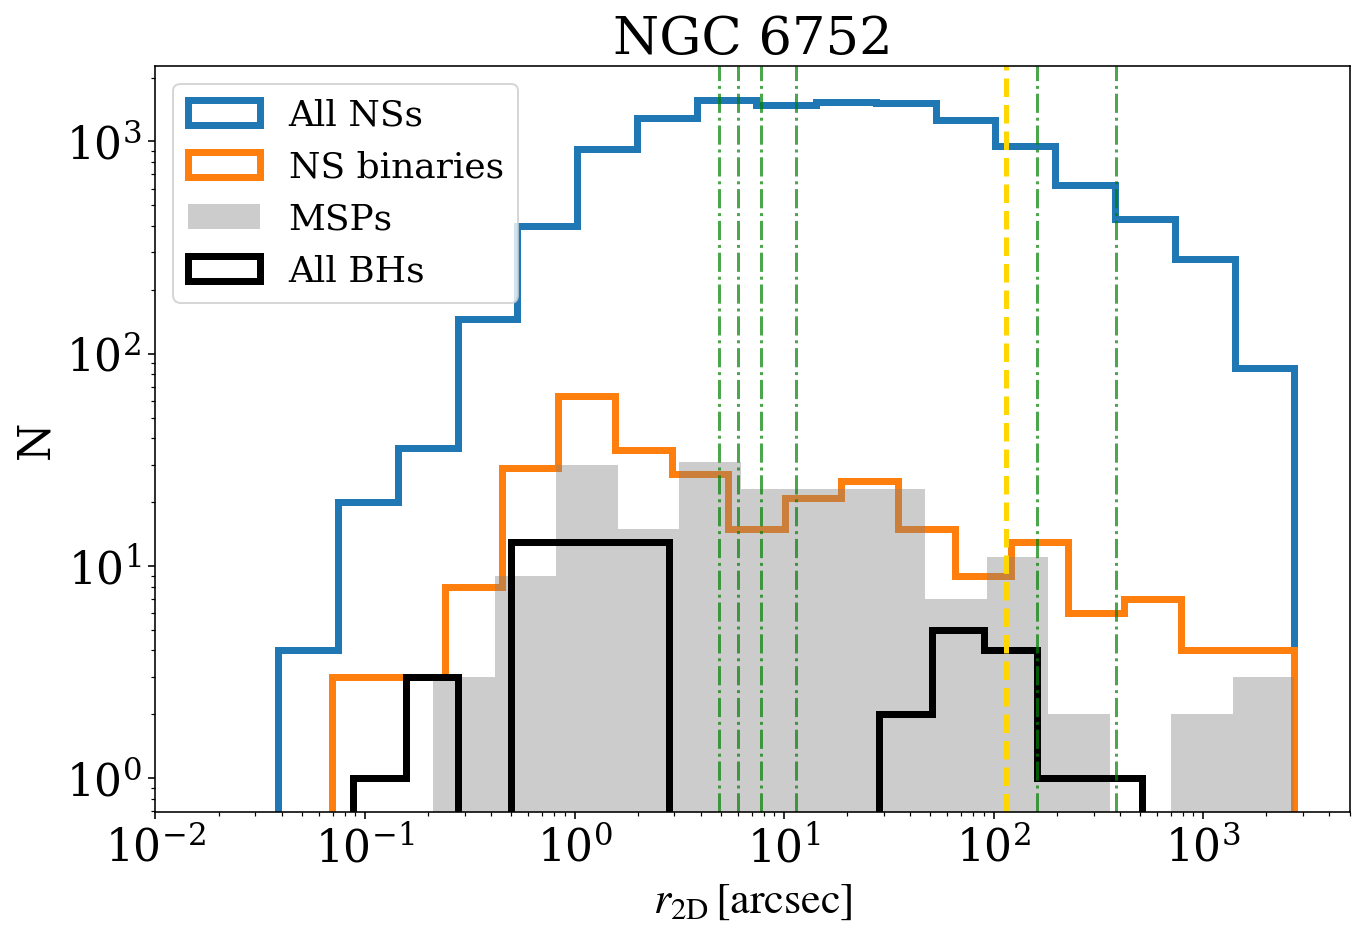

In [4]:
# All single NS and NS-WD Offset Distributions in 6752
##Fiducial model
d6752 = 4.125 ##kpc

##Cumulative radial distribution
path_6752 = paths[0]#'/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap2d = np.sort(glob(path_6752+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_6752+'initial.snap*.cluster_params.dat'))

#snap2d_unsort=np.array(glob(path_6752+'*.snap*.2Dproj.dat.gz'))
#clus_param_unsort=np.array(glob(path_6752+'initial.snap*.cluster_params.dat'))
#snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
#       
#clusno_unsort=[int((x.split('.')[-3]).split('p')[1]) for x in clus_param_unsort]
#clusno, clus_param = zip(*sorted(zip(clusno_unsort,clus_param_unsort)))
#print(snap2dno, snap2d)
    
rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
rpc_nsbin = []
rpc_bh = []
id_2dmsp = []; idcomp_2dmsp = []; t_2dmsp = []; snapno_2dmsp = []; id_2dall = []; id_2dallmsp = []
id_2dbin = []; idcomp_2dbin = []; t_2dbin = []; snapno_2dbin = []
n_nonmsp_sin = 0; n_msp_sin = 0
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<11000.: continue
    if data_param[0][0]>14000.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
        
    ##First make the MSP files
    #ns_hdf5.get_allpsr_atsnap(path_6752, 'MSP', thesnapno, 4.125, 0.0002)
        
    ##Now extract data from multiple snapshots
    datamsp = np.genfromtxt(path_6752+'MSP'+str(thesnapno)+'.dat')
    id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
    
    with gzip.open(path_6752+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 14 or int(data2d[6]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                    if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        rpc_nsbin.append(float(data2d[0]))
                        if int(data2d[5]) == 13:
                            id_2dbin.append(int(float(data2d[13])))
                            idcomp_2dbin.append(int(float(data2d[14])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            id_2dall.append(str(int(float(data2d[13])))+'-'+str(int(float(data2d[14]))))

                        elif int(data2d[6]) == 13: 
                            id_2dbin.append(int(float(data2d[14])))
                            idcomp_2dbin.append(int(float(data2d[13])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            id_2dall.append(str(int(float(data2d[14])))+'-'+str(int(float(data2d[13]))))

                            
                        if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            if float(data2d[13]) in id_msp:
                                id_2dmsp.append(int(float(data2d[13])))
                                idcomp_2dmsp.append(int(float(data2d[14])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                                id_2dallmsp.append(str(int(float(data2d[13])))+'-'+str(int(float(data2d[14]))))

                            if float(data2d[14]) in id_msp:
                                id_2dmsp.append(int(float(data2d[14])))
                                idcomp_2dmsp.append(int(float(data2d[13])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                                id_2dallmsp.append(str(int(float(data2d[14])))+'-'+str(int(float(data2d[13]))))

                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            
                else:
                    if int(data2d[3]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                    if int(data2d[3]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        if float(data2d[12]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            id_2dmsp.append(int(float(data2d[12])))
                            idcomp_2dmsp.append(-100)
                            t_2dmsp.append(data_param[0][0])
                            snapno_2dmsp.append(thesnapno)
                            n_msp_sin+=1
                            id_2dallmsp.append(str(int(float(data2d[12])))+'--100')

                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            n_nonmsp_sin+=1
                        
r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
r_proj_bh = np.array(rpc_bh)/(d6752*1000.)*180/np.pi*60*60    
    #print(np.mean(m_tot), np.mean(mtot_msp), np.mean(mtot_nonmsp))
    #print(np.median(m_tot), np.median(mtot_msp), np.median(mtot_nonmsp))
    #print(len(m_tot), len(mtot_msp), len(mtot_nonmsp))
    #print(n_msp_sin, n_nonmsp_sin)

print(np.max(r_proj))

print(len(r_proj_msp[r_proj_msp>1.91*60.])/len(r_proj_msp))
print(len(r_proj_nsbin[r_proj_nsbin>1.91*60.])/len(r_proj_nsbin))
print(len(r_proj[r_proj>1.91*60.])/len(r_proj))

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All NSs')
axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_nsbin) / float(len(r_proj_nsbin)),
         histtype = 'step', lw = 3.5, label = 'NS binaries')
axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(np.max(r_proj)), 15), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_msp) / float(len(r_proj_msp)),
         color = 'grey', lw = 3., alpha=0.4, label = 'MSPs')
axs.hist(r_proj_bh, bins = np.logspace(np.log10(min(r_proj_bh)), np.log10(np.max(r_proj_bh)), 20), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All BHs', color='k')
[axs.axvline(_x, lw = 1.5, color = 'green', alpha=0.7, ls='dashdot') for _x in psroffsets]
axs.axvline(x=1.91*60., lw = 2.5, color = 'gold', ls='--')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.01, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
axs.set_ylabel('N')
axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 6752')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

#plt.savefig(savepath+'offsets_11to13dot5_new6752.pdf', dpi=300)
print('msp', #np.array(id_2dmsp)[r_proj_msp>1.91*60.], np.array(idcomp_2dmsp)[r_proj_msp>1.91*60.],
      np.array(id_2dallmsp)[r_proj_msp>1.91*60.],
      np.array(t_2dmsp)[r_proj_msp>1.91*60.])
print('msp', np.array(snapno_2dmsp)[r_proj_msp>1.91*60.])
print('nsbin', #np.array(id_2dbin)[r_proj_nsbin>1.91*60.], np.array(idcomp_2dbin)[r_proj_nsbin>1.91*60.],
      np.array(id_2dall)[r_proj_nsbin>1.91*60.],
      np.array(t_2dbin)[r_proj_nsbin>1.91*60.])
print('nsbin', np.array(snapno_2dbin)[r_proj_nsbin>1.91*60.])

In [ ]:
#snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/471(t=15.521915)',
#                     conv=paths[0]+'initial.conv.sh', 
#                     z=0.0002)
#
#id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
#sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
#k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
#r = np.array(snap.data['r'])
#
#print(0.5*r[(id0==1153004) | (id1==1153004)], k0[(id0==1153004) | (id1==1153004)], k1[(id0==1153004) | (id1==1153004)])


snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/506(t=19.966985)',#'/505(t=19.783743)',
                     conv=paths[0]+'initial.conv.sh', 
                     z=0.0002)

id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
r = np.array(snap.data['r'])

print(0.5*r[(id0==1534911) | (id1==1534911)], k0[(id0==1534911) | (id1==1534911)], k1[(id0==1534911) | (id1==1534911)])

snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/466(t=15.027318)',#'/505(t=19.783743)',
                     conv=paths[0]+'initial.conv.sh', 
                     z=0.0002)

id_star = np.array(snap.data['id'])
id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
r = np.array(snap.data['r'])

print(0.5*r[(id_star==1085042)])

[4.82196786] [10] [13]
[0.04295018]


9131.220961464
706
9271.658365928
709
9392.624490592
712
9520.431018
715
9718.22153442
718
9822.276406292
721
10024.197875384
724
10301.095562464
727
10416.954415616001
730
10549.322533848
733
10732.408762908
736
10974.265419152
739
11157.077265152
742
11399.214916096
745
11554.970608888
748
11708.552614835999
751
11882.765361852
754
3773.5781232452746
0.08523409363745499
0.05986509274873524
0.2159257029839195
msp ['1660000-3036407' '154126-12318' '97908-750438' '1793013-3039287'
 '97908-750438' '154126-12318' '1793013-3039287' '1660000-3036407'
 '154126-12318' '97908-750438' '1793013-3039287' '1660000-3036407'
 '1354220-3029726' '97908-750438' '154126-12318' '1660000-3036407'
 '1793013-3039287' '1354220-3029726' '1660000-3036407' '97908-750438'
 '154126-12318' '1793013-3039287' '97908-750438' '1660000-3036407'
 '1793013-3039287' '97908-750438' '154126-12318' '1793013-3039287'
 '1660000-3036407' '97908-750438' '154126-12318' '1660000-3036407'
 '1793013-3039287' '154126-12318' '97908-75

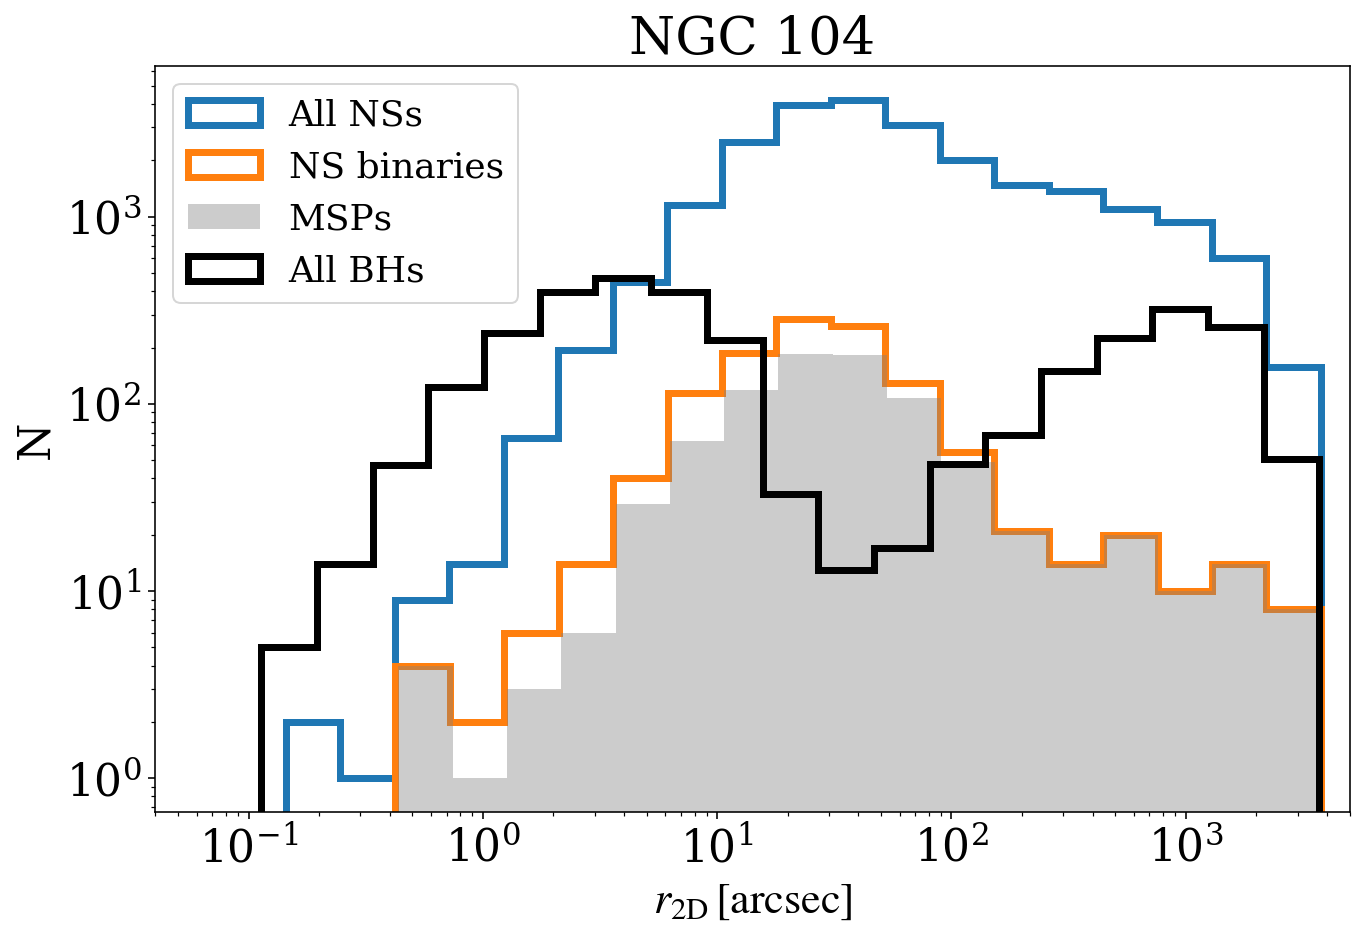

In [11]:
# All single NS and NS-WD Offset Distributions in 47 Tuc
##Fiducial model
d104 = 4.52 ##kpc
rhl104 = 3.17 ##half-light radius in arcmin

#snapno=488 ##12 Gyr

##Cumulative radial distribution
path_47 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/'
path_47_1 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'

snap2d = np.sort(glob(path_47+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_47+'initial.snap*.cluster_params.dat'))
#print(snap2d,clus_param)   

rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
rpc_nsbin = []
rpc_bh = []
id_2dmsp = []; idcomp_2dmsp = []; t_2dmsp = []; snapno_2dmsp = []; id_2dall = []; id_2dallmsp = []
id_2dbin = []; idcomp_2dbin = []; t_2dbin = []; snapno_2dbin = []
n_nonmsp_sin = 0; n_msp_sin = 0
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<9000.: continue
    if data_param[0][0]>12000.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
        
    ##First make the MSP files
    #ns_hdf5.get_allpsr_atsnap(path_47_1, 'MSP_obs_profile', thesnapno, 4.52, 0.0038)
        
    ##Now extract data from multiple snapshots
    datamsp = np.genfromtxt(path_47_1+'MSP_obs_profile'+str(thesnapno)+'.dat')
    id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
    
    with gzip.open(path_47+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 14 or int(data2d[6]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                    if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        rpc_nsbin.append(float(data2d[0]))
                        if int(data2d[5]) == 13:
                            id_2dbin.append(int(float(data2d[13])))
                            idcomp_2dbin.append(int(float(data2d[14])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            id_2dall.append(str(int(float(data2d[13])))+'-'+str(int(float(data2d[14]))))
                        if int(data2d[6]) == 13: 
                            id_2dbin.append(int(float(data2d[14])))
                            idcomp_2dbin.append(int(float(data2d[13])))
                            t_2dbin.append(data_param[0][0])
                            snapno_2dbin.append(thesnapno)
                            id_2dall.append(str(int(float(data2d[14])))+'-'+str(int(float(data2d[13]))))
                        if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            if float(data2d[13]) in id_msp:
                                id_2dmsp.append(int(float(data2d[13])))
                                idcomp_2dmsp.append(int(float(data2d[14])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                                id_2dallmsp.append(str(int(float(data2d[13])))+'-'+str(int(float(data2d[14]))))
                            if float(data2d[14]) in id_msp:
                                id_2dmsp.append(int(float(data2d[14])))
                                idcomp_2dmsp.append(int(float(data2d[13])))
                                t_2dmsp.append(data_param[0][0])
                                snapno_2dmsp.append(thesnapno)
                                id_2dallmsp.append(str(int(float(data2d[14])))+'-'+str(int(float(data2d[13]))))
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            
                else:
                    if int(data2d[3]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                    if int(data2d[3]) == 13: 
                        rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                        if float(data2d[12]) in id_msp:
                            rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                            id_2dmsp.append(int(float(data2d[12])))
                            idcomp_2dmsp.append(-100)
                            t_2dmsp.append(data_param[0][0])
                            snapno_2dmsp.append(thesnapno)
                            n_msp_sin+=1
                            id_2dallmsp.append(str(int(float(data2d[12])))+'--100')
                        else:
                            mtot_nonmsp.append(float(data2d[9]))
                            n_nonmsp_sin+=1
                        
r_proj = np.array(rpc)/(d104*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d104*1000.)*180/np.pi*60*60
r_proj_nsbin = np.array(rpc_nsbin)/(d104*1000.)*180/np.pi*60*60
r_proj_bh = np.array(rpc_bh)/(d104*1000.)*180/np.pi*60*60
    
    #print(np.mean(m_tot), np.mean(mtot_msp), np.mean(mtot_nonmsp))
    #print(np.median(m_tot), np.median(mtot_msp), np.median(mtot_nonmsp))
    #print(len(m_tot), len(mtot_msp), len(mtot_nonmsp))
    #print(n_msp_sin, n_nonmsp_sin)

print(np.max(r_proj))

print(len(r_proj_msp[r_proj_msp>rhl104*60.])/len(r_proj_msp))
print(len(r_proj_nsbin[r_proj_nsbin>rhl104*60.])/len(r_proj_nsbin))
print(len(r_proj[r_proj>rhl104*60.])/len(r_proj))

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(np.max(r_proj)), 20), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All NSs')
axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_nsbin) / float(len(r_proj_nsbin)),
         histtype = 'step', lw = 3.5, label = 'NS binaries')
axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(np.max(r_proj)), 18), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj_msp) / float(len(r_proj_msp)),
         color = 'grey', lw = 3., alpha=0.4, label = 'MSPs')
axs.hist(r_proj_bh, bins = np.logspace(np.log10(min(r_proj_bh)), np.log10(np.max(r_proj_bh)), 20), 
         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
         histtype = 'step', lw = 3.5, label = 'All BHs', color='k')
#[axs.axvline(_x, lw = 1.5, color = 'green', alpha=0.7, ls='dashdot') for _x in psroffsets_47Tuc]
#axs.axvline(x=rhl104*60., lw = 2.5, color = 'gold', ls='--')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.04, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
axs.set_ylabel('N')
axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 104')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

#plt.savefig(savepath+'offsets_9to12_47tuc.pdf', dpi=300)
print('msp', #np.array(id_2dmsp)[r_proj_msp>rhl104*60.], np.array(idcomp_2dmsp)[r_proj_msp>rhl104*60.],
      np.array(id_2dallmsp)[r_proj_msp>rhl104*60.],
      np.array(t_2dmsp)[r_proj_msp>rhl104*60.])
print('msp', np.array(snapno_2dmsp)[r_proj_msp>rhl104*60.])
print('nsbin', #np.array(id_2dbin)[r_proj_nsbin>rhl104*60.], np.array(idcomp_2dbin)[r_proj_nsbin>rhl104*60.],
      np.array(id_2dall)[r_proj_nsbin>rhl104*60.],
      np.array(t_2dbin)[r_proj_nsbin>rhl104*60.])
print('nsbin', np.array(snapno_2dbin)[r_proj_nsbin>rhl104*60.])

10549.322533848
733
[ 358545 1626458 1660896 1687721 1688348 1708515 1713594 1722034 1730280
 1746600 1762010 1776843 1807774 1828311 1839295 1839710 1854358 1857190
 1863622 1868601 1873455 1880403 1893891 1898029 1898573 1898788 1928676
 1929556 1929700 1931537 1946223 1957914 1959927 1963781 1973337 1975807
 1991349 2003136 2009672 2011214 2020987 2021746 2025315 2027294 2043752
 2062503 2063409 2077003 2085629 2089709 2095244 2103410 2111599 2139591
 2168208 2169049 2181573 2186646 2194394 2196826 2202629 2214210 2259488
 2263666 2274226 2274853 3202456] [   -100    -100    -100    -100    -100    -100    -100    -100    -100
    -100    -100    -100    -100    -100    -100    -100    -100    -100
    -100    -100    -100    -100    -100    -100    -100    -100    -100
    -100    -100    -100    -100    -100    -100    -100    -100    -100
 3043624    -100    -100    -100    -100    -100    -100    -100    -100
    -100    -100    -100    -100    -100    -100    -100    -100    -1

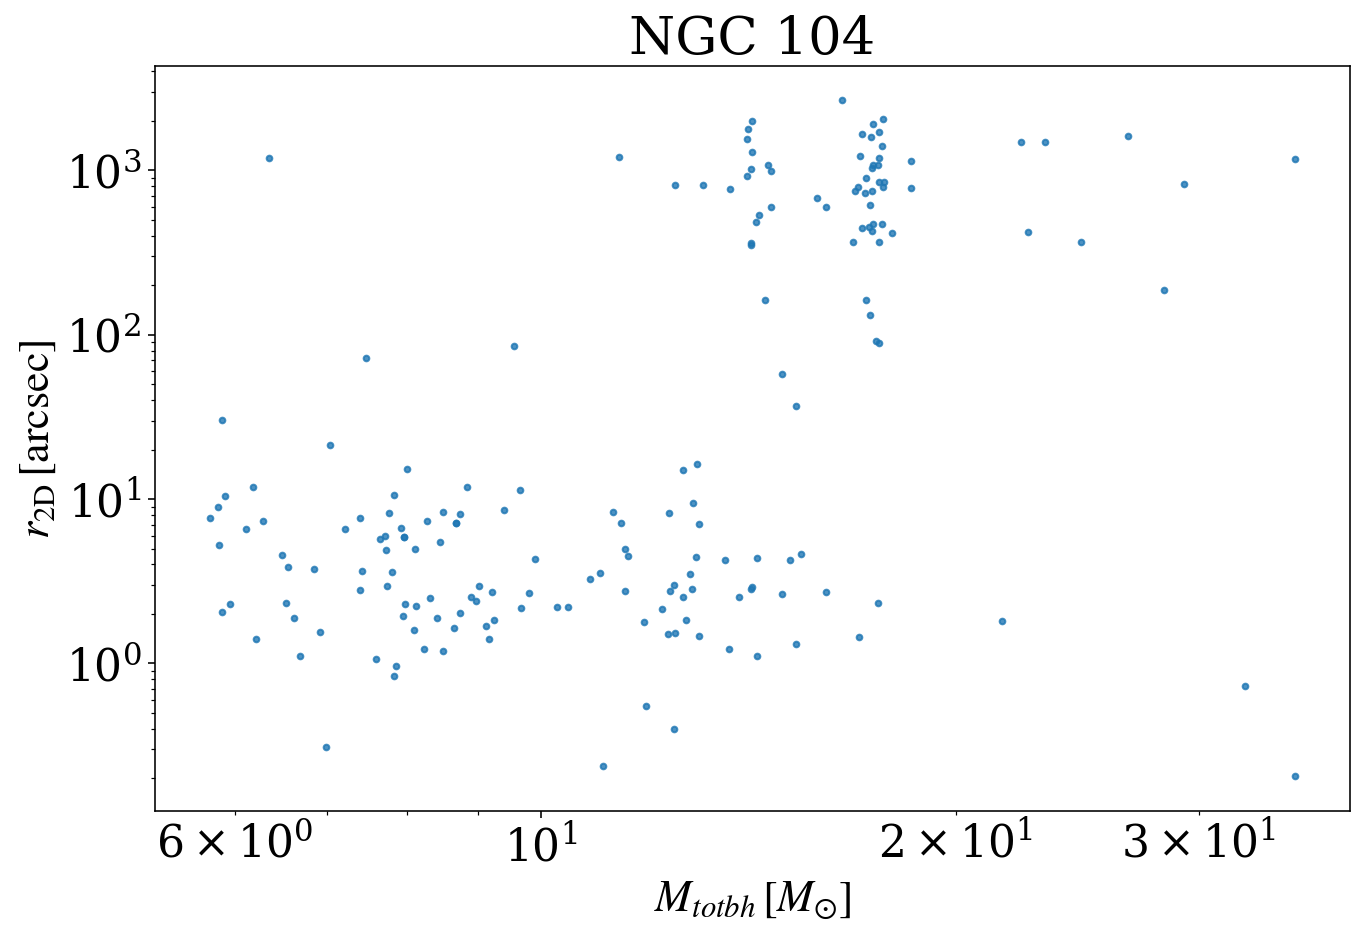

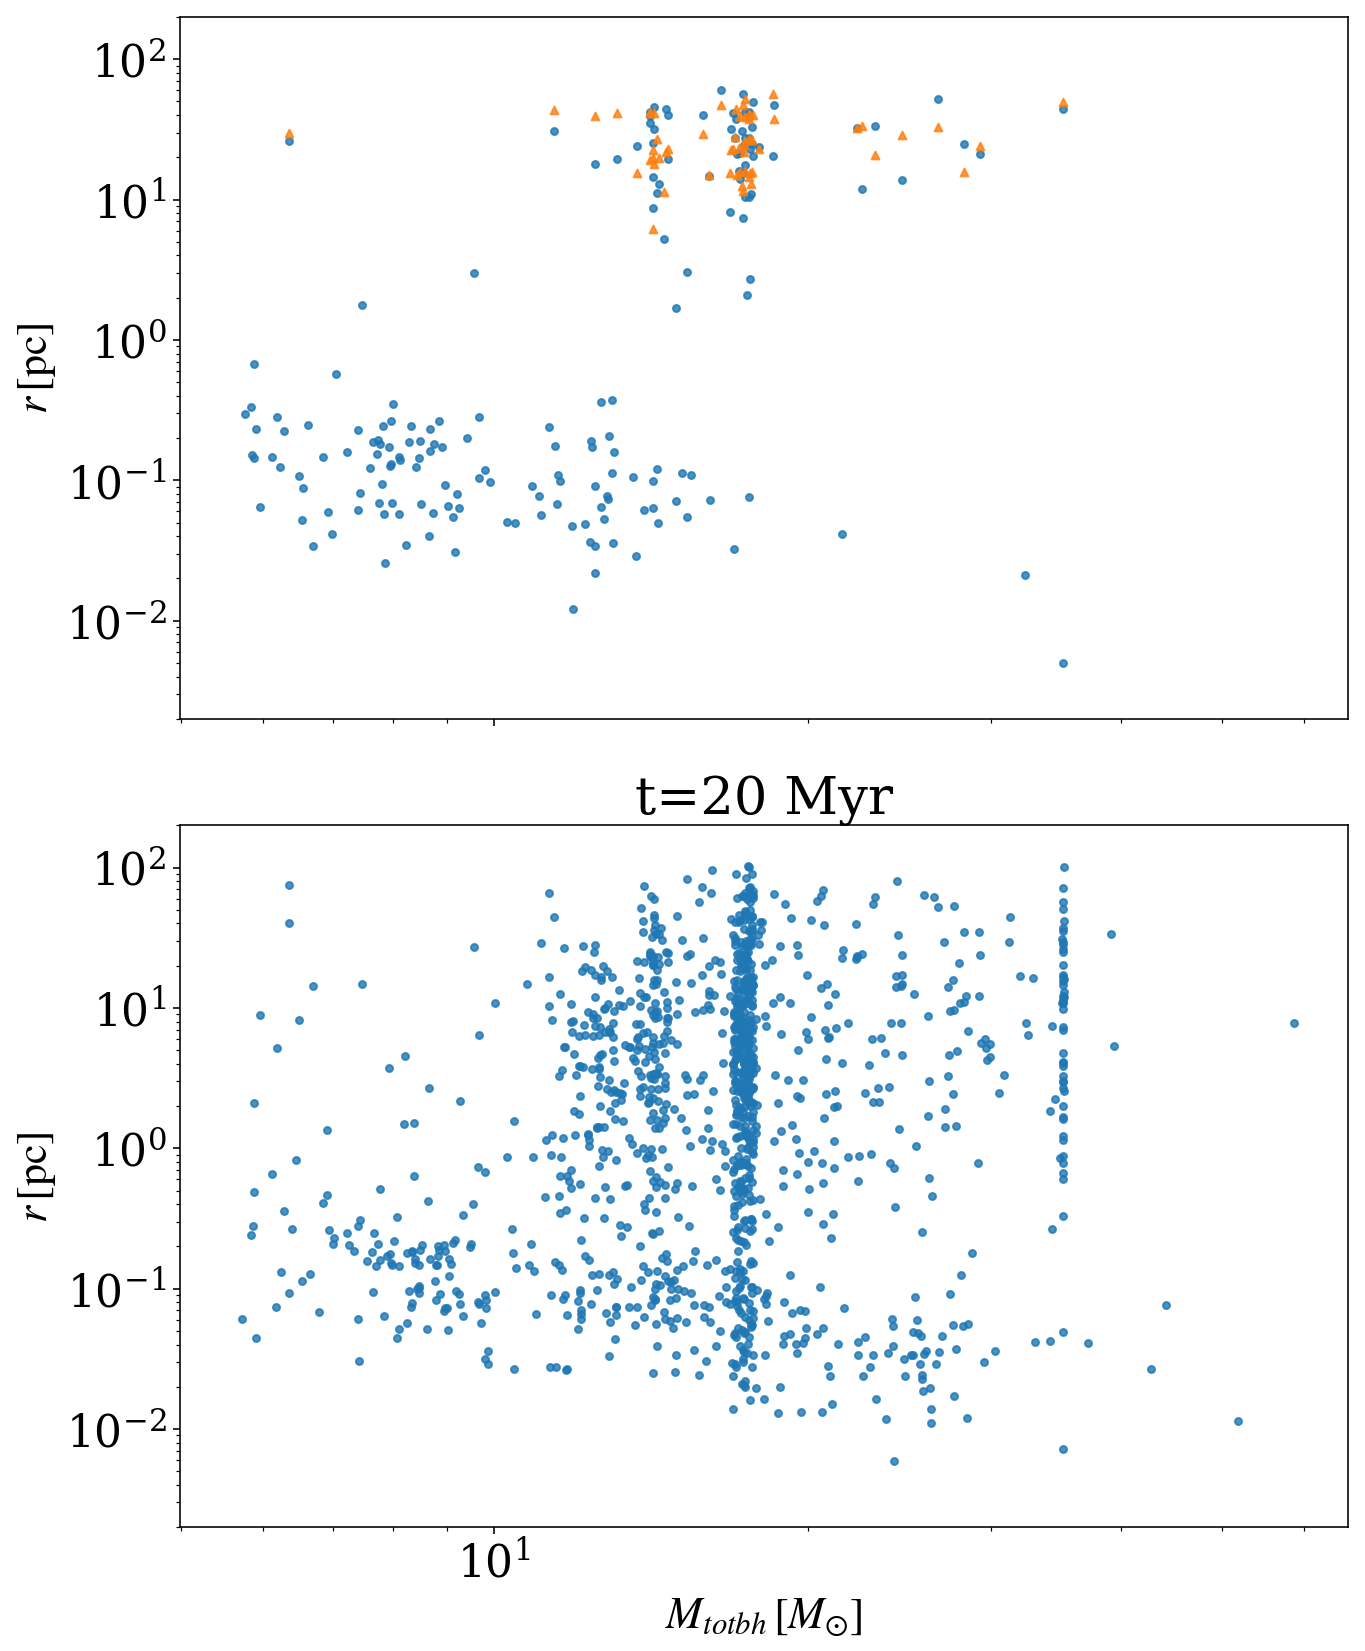

In [24]:
##Check why the BHs have double peaks 47 Tuc
d104 = 4.52 ##kpc
rhl104 = 3.17 ##half-light radius in arcmin

#snapno=488 ##12 Gyr

##Cumulative radial distribution
path_47 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/'
path_47_1 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'

l_conv = dyn.conv('l', path_47_1+'initial.conv.sh')
#############Projected#####################
snap2d = np.sort(glob(path_47+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_47+'initial.snap*.cluster_params.dat'))
#print(snap2d,clus_param)   

#rpc_bh = []; mtot_bh = []; id_bhs = []; id_comps = []
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<10500.: continue
    if data_param[0][0]>10700.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
    
    rpc_bh = []; mtot_bh = []; id_bhs = []; id_comps = []
    
    ##Now extract data from multiple snapshots
    with gzip.open(path_47+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 14 or int(data2d[6]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                        mtot_bh.append(float(data2d[9]))
                        if int(data2d[5]) == 14:
                            id_bhs.append(int(float(data2d[13])))
                            id_comps.append(int(float(data2d[14])))
                        elif int(data2d[6]) == 14:
                            id_bhs.append(int(float(data2d[14])))
                            id_comps.append(int(float(data2d[13])))
                            
                else:
                    if int(data2d[3]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                        mtot_bh.append(float(data2d[9]))
                        id_bhs.append(int(float(data2d[12])))
                        id_comps.append(-100)

    
    id_bhs = np.array(id_bhs); id_comps = np.array(id_comps)
    mtot_bh = np.array(mtot_bh)
    r_proj_bh = np.array(rpc_bh)/(d104*1000.)*180/np.pi*60*60
    print(np.sort(id_bhs[r_proj_bh>=50]),id_comps[r_proj_bh>=50], len(id_bhs[r_proj_bh>=50]))

                        
#id_bhs = np.array(id_bhs); id_comps = np.array(id_comps)
#r_proj_bh = np.array(rpc_bh)/(d104*1000.)*180/np.pi*60*60
  

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
#axs.hist(mtot_bh, bins=np.logspace(np.log10(min(mtot_bh)), np.log10(np.max(mtot_bh)), 20), 
#         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
#         histtype = 'step', lw = 3.5, label = 'All BHs', color='k')
axs.scatter(mtot_bh, r_proj_bh, alpha=0.8, s=8)

axs.set_xscale('log')
axs.set_yscale('log')
#axs.set_xlim(xmin = 0.04, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$M_{totbh}\,[M_{\odot}]$')
axs.set_ylabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
#axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 104')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

print(len(r_proj_bh))
#print(id_bhs[r_proj_bh>=50],id_comps[r_proj_bh>=50], len(id_bhs[r_proj_bh>=50]))


#####################3D######################
snap = cmct.Snapshot(fname=path_47_1+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)',
                     conv=path_47_1+'initial.conv.sh', 
                     z=0.0038)

binflag = np.array(snap.data['binflag'])
ids = np.array(snap.data['id'])
mtot = np.array(snap.data['m_MSUN'])
ktype = np.array(snap.data['startype'])
id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
rpc = np.array(snap.data['r'])*l_conv
print('mass within', np.sum(mtot[rpc<=10]))

mtot_bh_3d = []; rpc_bh_3d = []; id_bh_3d = []
for xx in range(len(mtot)):
    if binflag[xx]!=1:
        if ktype[xx]==14:
            mtot_bh_3d.append(mtot[xx])
            rpc_bh_3d.append(rpc[xx])
            id_bh_3d.append(int(ids[xx]))
    else:
        if k0[xx]==14:
            mtot_bh_3d.append(mtot[xx])
            rpc_bh_3d.append(rpc[xx])
            id_bh_3d.append(int(id0[xx]))
        elif k1[xx]==14:
            mtot_bh_3d.append(mtot[xx])
            rpc_bh_3d.append(rpc[xx])
            id_bh_3d.append(int(id1[xx]))
            
            
#mtot_bh_3d  = mtot[(ktype==14) | ((k0==14) | (k1==14))]
#rpc_bh_3d  = rpc[(ktype==14) | ((k0==14) | (k1==14))]

id_bh_3d = np.array(id_bh_3d)
rpc_bh_3d = np.array(rpc_bh_3d)
print(len(rpc_bh_3d))


#########Formation location############
bhform = path_47_1+'initial.bhformation.dat'
rpc_bhform = []; id_bhform = []; m_bhform = []; m_bhnow = []
with open(bhform, 'r') as fbhform:
    next(fbhform)
    for line in fbhform:
        databh = line.split()
        if int(databh[3]) in id_bh_3d[rpc_bh_3d>=7]:
            rpc_bhform.append(float(databh[1])*l_conv)
            id_bhform.append(int(databh[3]))
            m_bhform.append(float(databh[6]))
            m_bhnow.append(mtot_bh[id_bh_3d==int(databh[3])][0])
        #else:
        #    rpc_bhform.append(100)
        #    id_bhform.append(int(databh[3]))
        #    m_bhform.append(float(databh[6]))
        #    m_bhnow.append(float(databh[6]))
print(len(rpc_bhform), len(rpc_bh_3d[rpc_bh_3d>=7]))


##
snap_bh = 'initial.blackhole.snapshots.h5'
with pd.HDFStore(path_47_1+snap_bh) as snap_hdf:
    snap_keys_bh = np.sort(snap_hdf.keys())
    
#print(snap_keys_bh)

for ii in range(5):
    rpc_bh_t = []
    thebh = id_bh_3d[rpc_bh_3d>=7][ii]
    for jj in range(0, len(snap_keys_bh), 7):
        #print(snap_keys_bh[jj])
        snap_bh = cmct.Snapshot(fname=path_47_1+'initial.blackhole.snapshots.h5', 
                                snapshot_name=snap_keys_bh[jj],
                                conv=path_47_1+'initial.conv.sh', 
                                z=0.0038)
        
        ids_bh = np.array(snap_bh.data['id'])
        ktypes_bh = np.array(snap_bh.data['startype'])
        rpcs_bh = np.array(snap_bh.data['r'])*l_conv
        
        if thebh in ids_bh:
            rpc_bh_t.append(rpcs_bh[ids_bh==thebh][0])
        else:
            rpc_bh_t.append(-100)
        
    print(rpc_bh_t)
    
###Mass of the cluster at the outskirt at t=0 and how many BHs do we expect from this mass
snap = cmct.Snapshot(fname=path_47_1+'initial.snapshots.h5', snapshot_name='/7(t=0.00091762085)',
                     conv=path_47_1+'initial.conv.sh', 
                     z=0.0038)

binflag7 = np.array(snap.data['binflag'])
ids7 = np.array(snap.data['id'])
mtot7 = np.array(snap.data['m_MSUN'])
ktype7 = np.array(snap.data['startype'])
id07 = np.array(snap.data['id0']); id17 = np.array(snap.data['id1'])
k07 = np.array(snap.data['bin_startype0']); k17 = np.array(snap.data['bin_startype1'])
rpc7 = np.array(snap.data['r'])*l_conv
print(np.sum(mtot7[rpc7>=50]), len(mtot7[rpc7>=50]))
print(np.sum(mtot7[(rpc7>=50) & (ktype7==14)]), 
      len(mtot7[(rpc7>=50) & (ktype7==14)]))


fig, axs = plt.subplots(nrows=2, figsize=(10,12), sharex=True)
axs[0].scatter(mtot_bh_3d, rpc_bh_3d, alpha=0.8, s=12)
axs[0].scatter(m_bhnow, rpc_bhform, alpha=0.8, s=15, marker = '^')
axs[1].scatter(mtot7[(ktype7==14) | (k07==14) | (k17==14)], 
            rpc7[(ktype7==14) | (k07==14) | (k17==14)], 
            alpha=0.8, s=12)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$M_{totbh}\,[M_{\odot}]$')
axs[0].set_ylabel(r'$r\,[\rm{pc}]$')
axs[1].set_ylabel(r'$r\,[\rm{pc}]$')
axs[0].set_ylim(ymin=0.002, ymax = 200)
axs[1].set_ylim(ymin=0.002, ymax = 200)
axs[1].set_title('t=20 Myr')
fig.tight_layout()

129.0332680848
101
[  36647  105339  205812  210902  235650  254328  287316  310114  317446
  391758  411441  422703  453089  467437  469264  557547  559732  571643
  572016  739049  766853  782059  816333  848417  958377 1012573] [  -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
   -100   -100 238603   -100   -100   -100   -100   -100   -100   -100
   -100 830211   -100   -100   -100   -100] 26
134.5368919628
104
[ 36647 105339 210902 235650 254328 287316 310114 317446 385439 391758
 422703 467437 469264 557547 559732 571643 572016 656210 720368 739049
 766853 782059 958377] [  -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
   -100   -100 830211   -100   -100   -100 238603   -100   -100   -100
   -100   -100   -100] 23
140.7918489548
107
[ 36647 210902 235650 254328 287316 287979 310114 317446 391758 401440
 422703 467437 469264 559732 571643 572016 656210 720368 739049 766853
 816333 958377] [ 20793   -100   -100   -100   -100   -100   -100 8

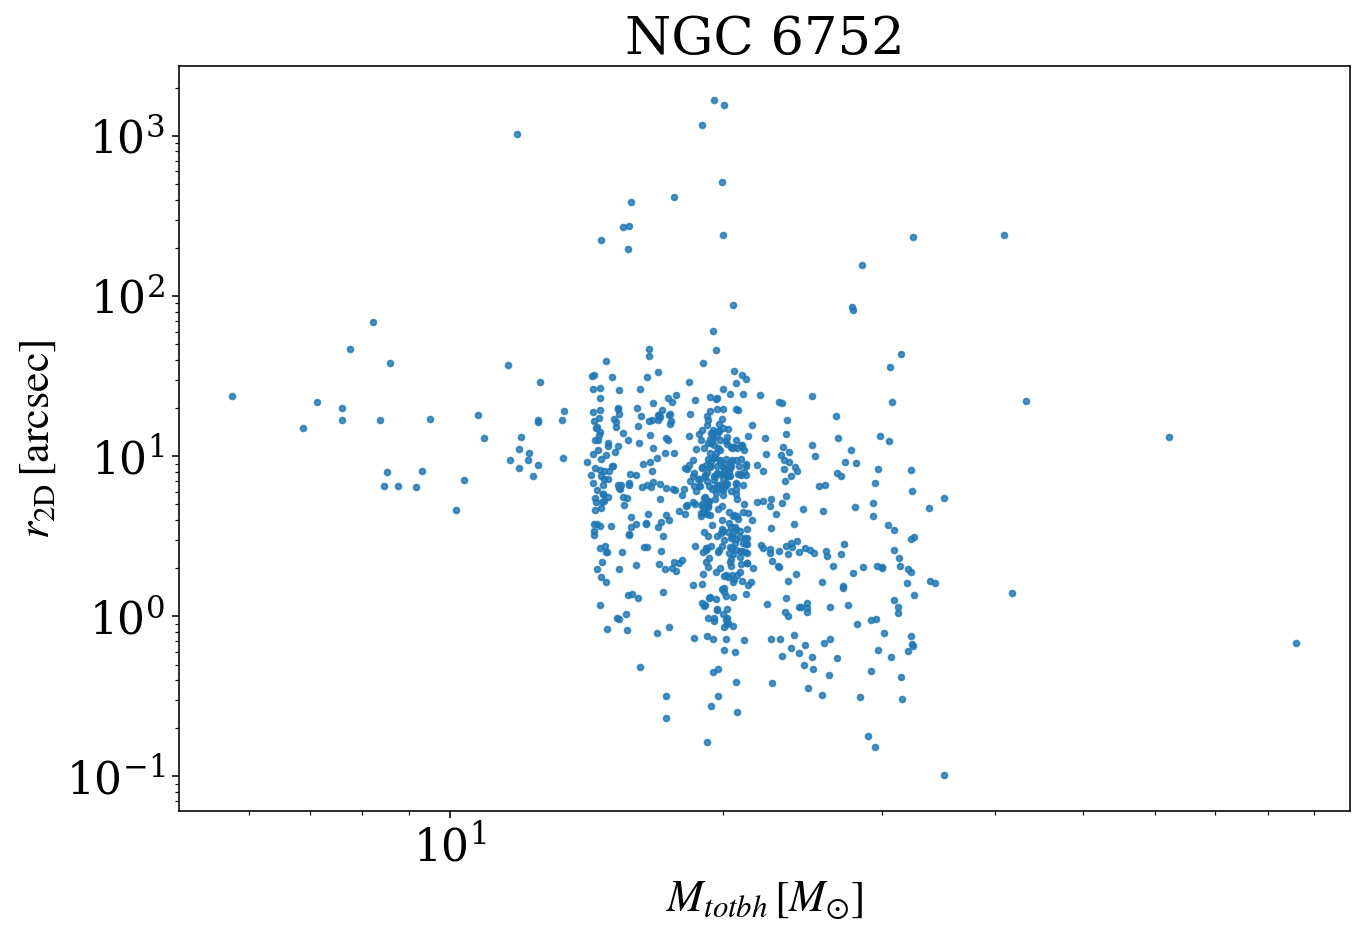

In [15]:
##Check why the BHs have double peaks NGC 6752
d6752 = 4.125 ##kpc
rhl6752 = 1.91 ##half-light radius in arcmin

l_conv = dyn.conv('l', paths[0]+'initial.conv.sh')
#############Projected#####################
snap2d = np.sort(glob(paths[0]+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(paths[0]+'initial.snap*.cluster_params.dat'))
#print(snap2d,clus_param)   

#rpc_bh = []; mtot_bh = []; id_bhs = []; id_comps = []
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<0.: continue
    if data_param[0][0]>150.: break
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)
    
    rpc_bh = []; mtot_bh = []; id_bhs = []; id_comps = []
    
    ##Now extract data from multiple snapshots
    with gzip.open(paths[0]+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
            next(f2d); next(f2d)
            for line in f2d:
                data2d = line.split()
                if int(data2d[2]) == 1:
                    if int(data2d[5]) == 14 or int(data2d[6]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                        mtot_bh.append(float(data2d[9]))
                        if int(data2d[5]) == 14:
                            id_bhs.append(int(float(data2d[13])))
                            id_comps.append(int(float(data2d[14])))
                        elif int(data2d[6]) == 14:
                            id_bhs.append(int(float(data2d[14])))
                            id_comps.append(int(float(data2d[13])))
                            
                else:
                    if int(data2d[3]) == 14: 
                        rpc_bh.append(float(data2d[0]))
                        mtot_bh.append(float(data2d[9]))
                        id_bhs.append(int(float(data2d[12])))
                        id_comps.append(-100)

    
    id_bhs = np.array(id_bhs); id_comps = np.array(id_comps)
    mtot_bh = np.array(mtot_bh)
    r_proj_bh = np.array(rpc_bh)/(d6752*1000.)*180/np.pi*60*60
    print(np.sort(id_bhs[r_proj_bh>=50]),id_comps[r_proj_bh>=50], len(id_bhs[r_proj_bh>=50]))
  

##Now make the plot by stacking multiple snapshots
fig, axs = plt.subplots(figsize = (10, 7))
#axs.hist(mtot_bh, bins=np.logspace(np.log10(min(mtot_bh)), np.log10(np.max(mtot_bh)), 20), 
#         cumulative = False, density = False, #weights = np.ones_like(r_proj) / float(len(r_proj)),
#         histtype = 'step', lw = 3.5, label = 'All BHs', color='k')
axs.scatter(mtot_bh, r_proj_bh, alpha=0.8, s=8)

axs.set_xscale('log')
axs.set_yscale('log')
#axs.set_xlim(xmin = 0.04, xmax = 5000.)
#axs.set_ylim(ymin=10**-5, ymax = 1.)
axs.set_xlabel(r'$M_{totbh}\,[M_{\odot}]$')
axs.set_ylabel(r'$r_{\rm{2D}}\,[\rm{arcsec}]$')
#axs.legend(loc = 'upper left', fontsize = 18)
axs.set_title('NGC 6752')
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

print(len(r_proj_bh))
#print(id_bhs[r_proj_bh>=50],id_comps[r_proj_bh>=50], len(id_bhs[r_proj_bh>=50]))


#####################3D######################
#snap = cmct.Snapshot(fname=paths[0]+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)',
#                     conv=paths[0]+'initial.conv.sh', 
#                     z=0.0038)
#
#binflag = np.array(snap.data['binflag'])
#ids = np.array(snap.data['id'])
#mtot = np.array(snap.data['m_MSUN'])
#ktype = np.array(snap.data['startype'])
#id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
#k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
#rpc = np.array(snap.data['r'])*l_conv
#
#mtot_bh_3d = []; rpc_bh_3d = []; id_bh_3d = []
#for xx in range(len(mtot)):
#    if binflag[xx]!=1:
#        if ktype[xx]==14:
#            mtot_bh_3d.append(mtot[xx])
#            rpc_bh_3d.append(rpc[xx])
#            id_bh_3d.append(int(ids[xx]))
#    else:
#        if k0[xx]==14:
#            mtot_bh_3d.append(mtot[xx])
#            rpc_bh_3d.append(rpc[xx])
#            id_bh_3d.append(int(id0[xx]))
#        elif k1[xx]==14:
#            mtot_bh_3d.append(mtot[xx])
#            rpc_bh_3d.append(rpc[xx])
#            id_bh_3d.append(int(id1[xx]))
#            
#            
##mtot_bh_3d  = mtot[(ktype==14) | ((k0==14) | (k1==14))]
##rpc_bh_3d  = rpc[(ktype==14) | ((k0==14) | (k1==14))]
#
#id_bh_3d = np.array(id_bh_3d)
#rpc_bh_3d = np.array(rpc_bh_3d)
#print(len(rpc_bh_3d))
#
#
##########Formation location############
#bhform = paths[0]+'initial.bhformation.dat'
#rpc_bhform = []; id_bhform = []; m_bhform = []; m_bhnow = []
#with open(bhform, 'r') as fbhform:
#    next(fbhform)
#    for line in fbhform:
#        databh = line.split()
#        if int(databh[3]) in id_bh_3d[rpc_bh_3d>=7]:
#            rpc_bhform.append(float(databh[1])*l_conv)
#            id_bhform.append(int(databh[3]))
#            m_bhform.append(float(databh[6]))
#            m_bhnow.append(mtot_bh[id_bh_3d==int(databh[3])][0])
#        #else:
#        #    rpc_bhform.append(100)
#        #    id_bhform.append(int(databh[3]))
#        #    m_bhform.append(float(databh[6]))
#        #    m_bhnow.append(float(databh[6]))
#print(len(rpc_bhform), len(rpc_bh_3d[rpc_bh_3d>=7]))
#
#
#fig, axs = plt.subplots(figsize=(10,7))
#axs.scatter(mtot_bh_3d, rpc_bh_3d, alpha=0.8, s=12)
#axs.scatter(m_bhnow, rpc_bhform, alpha=0.8, s=15, marker = '^')
#axs.set_xscale('log')
#axs.set_yscale('log')
#axs.set_xlabel(r'$M_{totbh}\,[M_{\odot}]$')
#axs.set_ylabel(r'$r\,[\rm{pc}]$')
#axs.set_ylim(ymin=0.002, ymax = 200)
#
###
#snap_bh = 'initial.blackhole.snapshots.h5'
#with pd.HDFStore(paths[0]+snap_bh) as snap_hdf:
#    snap_keys_bh = np.sort(snap_hdf.keys())
#    
##print(snap_keys_bh)
#
#for ii in range(5):
#    rpc_bh_t = []
#    thebh = id_bh_3d[rpc_bh_3d>=7][ii]
#    for jj in range(0, len(snap_keys_bh), 7):
#        #print(snap_keys_bh[jj])
#        snap_bh = cmct.Snapshot(fname=paths[0]+'initial.blackhole.snapshots.h5', 
#                                snapshot_name=snap_keys_bh[jj],
#                                conv=paths[0]+'initial.conv.sh', 
#                                z=0.0038)
#        
#        ids_bh = np.array(snap_bh.data['id'])
#        ktypes_bh = np.array(snap_bh.data['startype'])
#        rpcs_bh = np.array(snap_bh.data['r'])*l_conv
#        
#        if thebh in ids_bh:
#            rpc_bh_t.append(rpcs_bh[ids_bh==thebh][0])
#        else:
#            rpc_bh_t.append(-100)
#        
#    print(rpc_bh_t)

In [4]:
##Check for primordial binary in 47 Tuc
path_47 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/'
path_47_1 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
snap = cmct.Snapshot(fname=path_47_1+'initial.snapshots.h5', snapshot_name='/0(t=0)',
                     conv=path_47_1+'initial.conv.sh', 
                     z=0.0038)

l_conv = dyn.conv('l', path_47_1+'initial.conv.sh')

id0 = np.array(snap.data['id0']); id1 = np.array(snap.data['id1'])
sma = np.array(snap.data['a_AU']); ecc = np.array(snap.data['e'])
k0 = np.array(snap.data['bin_startype0']); k1 = np.array(snap.data['bin_startype1'])
rpc = np.array(snap.data['r'])*l_conv

ids_msp = [1660000, 154126, 97908, 1793013, 1354220, 890912]
for xx in range(len(ids_msp)):
    if ids_msp[xx] in id0:
        print(ids_msp[xx], id1[id0==ids_msp[xx]], rpc[id0==ids_msp[xx]])
    elif ids_msp[xx] in id1:
        print(ids_msp[xx], id0[id1==ids_msp[xx]], rpc[id1==ids_msp[xx]])

1660000 [3036407] [8.60258034]
1793013 [3039287] [12.44293887]
1354220 [3029726] [3.86242253]


In [ ]:
##Check the orbital eccentricity of a binary in a cluster
l_conv = 0.5  ##pc
tnbody_conv = 0.00757051 ##Myr

E = -0.0066695411*(l_conv/tnbody_conv)**2
J = 1.0281208*l_conv**2/tnbody_conv
M = 484844*0.4 ##just an estimate of late time mass
mu = 2.362331+0.008387

G_sun_pc_myr = Gconst_sun*(yearsc*10**6)**2/(PC/10**5)**2

ecc_bin = math.sqrt(1 + 2*E*J**2/(G_sun_pc_myr*M)**2)

print(ecc_bin)

The three furthest away MSPs are 331891, 352346, 104900<br />
104900: Last fewbody interaction (BS) at 16.3694274 (11 Gyr)<br />
        Merger with an ONe WD at 16.7245 (11.3 Gyr)<br />
        Offset mostly because of Fewbody exchange encounter with WD-WD binary<br />
352346: Last fewbody interaction (BS) at 17.590919 (11.9 Gyr)<br />
        Offset because of Fewbody exchaneg encounter with WD-WD binary<br />
331891: Last fewbody interaction (BS) at 15.0088356 (10.1 Gyr)<br />
        Offset because of accretion-induced collapse<br />

In [9]:
##Check the positions of the MSPs before and after fewbody interactions
id_far = [331891,104900,352346]
t_fewbody = [15.0088356,16.3694274,17.590919]

l_conv = dyn.conv('l', paths[0]+'initial.conv.sh')
with open(paths[0]+'initial.morepulsars.dat', 'r') as fpsr:
    next(fpsr)
    for xx in range(len(id_far)):
        r_prev = 0; t_prev = 0
        r_post = 0; t_post = 0
        for line in fpsr:
            data = line.split()
            if float(data[1])<14.:
                continue
            
            if int(data[2])==1:
                if float(data[1])<=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
                    
                if float(data[1])<=t_fewbody[xx] and int(data[4])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[4])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
                    
            else:
                if float(data[1])<=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_prev = float(data[19])*l_conv
                    t_prev = float(data[1])
                elif float(data[1])>=t_fewbody[xx] and int(data[3])==int(id_far[xx]):
                    r_post = float(data[19])*l_conv
                    t_post = float(data[1])
                    break
        print(id_far[xx], t_fewbody[xx], t_prev, r_prev, t_post, r_post)
        

331891 15.0088356 0 0 15.027318 0.0339592525
104900 16.3694274 16.361096 0.0269123745 16.380958 30.0083275
352346 17.590919 17.585414 0.63198395 17.631273 4.106865


13800.0
10383.8
470
[]
[]
11054.5
476
[1306.48878331]
[1306.48878331]
11492.8
482
[]
[1794.32880179]
11984.7
488
[156.14370842]
[ 126.15655586  156.14370842 1650.34846649]
12684.6
497
[]
[221.48889907]


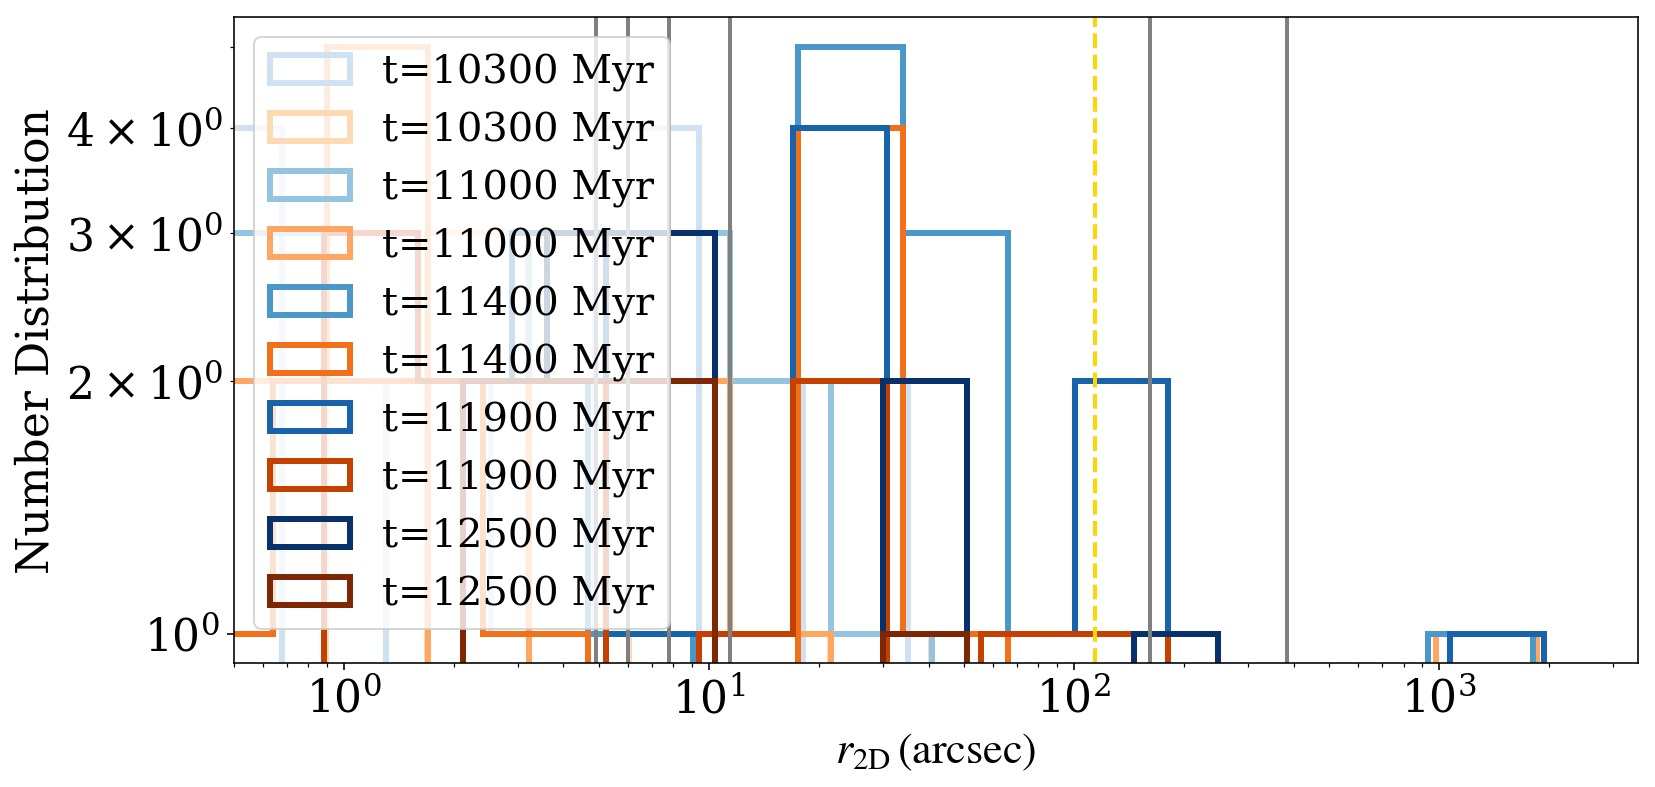

In [42]:
####All single NS and NS-WD Offset Distributions
##Comparing multiple snapshots
d6752 = 4.125 ##kpc

t_conv = dyn.conv('t', paths[0]+'initial.conv.sh')
snap2d_unsort=np.array(glob(paths[0]+'*.snap*.2Dproj.dat.gz'))
snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2d = snap2d_unsort[snap2dno.argsort()]
snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
print(ns.get_time(snap2d[-1]))

t_steps = [10300., 11000., 11400., 11900., 12500.]

csall = cm.Blues(np.linspace(0.2, 1, 5))
csbin = cm.Oranges(np.linspace(0.2, 1, 5))
##Cumulative radial distribution
fig, axs = plt.subplots(figsize = (12,6))
for hh in range(len(t_steps)):
    rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
    rpc_mspbin = []
    rpc_nsbin = []
    id_2dmsp = []
    n_nonmsp_sin = 0; n_msp_sin = 0
    for xx in range(len(snap2d)):
        if os.stat(snap2d[xx]).st_size==0:
            continue
        if ns.get_time(snap2d[xx])>=t_steps[hh]:
            print(ns.get_time(snap2d[xx]))

            if os.path.exists(paths[0]+'MSP'+str(snap2dno[xx])+'.dat'):
                datamsp = np.genfromtxt(paths[0]+'MSP'+str(snap2dno[xx])+'.dat')
                id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
            else:
                ns_hdf5.get_allpsr_atsnap(paths[0], 'MSP', snap2dno[xx], d6752, 0.0002)
                datamsp = np.genfromtxt(paths[0]+'MSP'+str(snap2dno[xx])+'.dat')
                id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
        
            with gzip.open(snap2d[xx], 'r') as f2d:
                    next(f2d); next(f2d)
                    for line in f2d:
                        data2d = line.split()
                        if int(data2d[2]) == 1:
                            if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                rpc_nsbin.append(float(data2d[0]))
                                if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    rpc_mspbin.append(float(data2d[0]))
                                    if float(data2d[13]) in id_msp:
                                        id_2dmsp.append(int(data2d[13]))
                                    if float(data2d[14]) in id_msp:
                                        id_2dmsp.append(int(float(data2d[14])))
                                else:
                                    mtot_nonmsp.append(float(data2d[9]))
                                    
                        else:
                            if int(data2d[3]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                if float(data2d[12]) in id_msp:
                                    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    id_2dmsp.append(int(data2d[12]))
                                    n_msp_sin+=1
                                else:
                                    mtot_nonmsp.append(float(data2d[9]))
                                    n_nonmsp_sin+=1
                                
            r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
            r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
            r_proj_mspbin = np.array(rpc_mspbin)/(d6752*1000.)*180/np.pi*60*60
            r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
            print(snap2dno[xx])
            print(r_proj_mspbin[r_proj_mspbin>=1.91*60.])
            print(r_proj_msp[r_proj_msp>=1.91*60.])
        
            #axs.hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 18), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'All NSs')
            #axs.hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(3500), 18), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'NS binaries')
            axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
                     cumulative = False, density = False,
                     histtype = 'step', lw = 3., color = csall[hh], label = 't='+str(int(t_steps[hh]))+' Myr')
            axs.hist(r_proj_mspbin, bins = np.logspace(np.log10(min(r_proj_mspbin)), np.log10(3500), 15), 
                     cumulative = False, density = False, 
                     histtype = 'step', lw = 3., color = csbin[hh], label = 't='+str(int(t_steps[hh]))+' Myr')
            
            
            break

[axs.axvline(_x, lw = 2., color = 'gray', ) for _x in psroffsets]
axs.axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
axs.set_ylabel('Number Distribution')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(xmin = 0.5, xmax = 3500.)
axs.set_xlabel(r'$r_{\rm{2D}}\,(\rm{arcsec})$')
axs.legend(loc = 'upper left', fontsize = 20)
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()


(2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 236, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305, 308, 311, 314, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383, 386, 389, 392, 395, 398, 401, 404, 407, 410, 413, 416, 419, 422, 425, 428, 431, 434, 437, 440, 443, 446, 449, 452, 455, 458, 461, 464, 467, 470, 473, 476, 479, 482, 485, 488, 491, 494, 497, 500, 503, 506, 509, 512)
13800.0
104.712
1024.41
5200.38
7886.29
10001.9


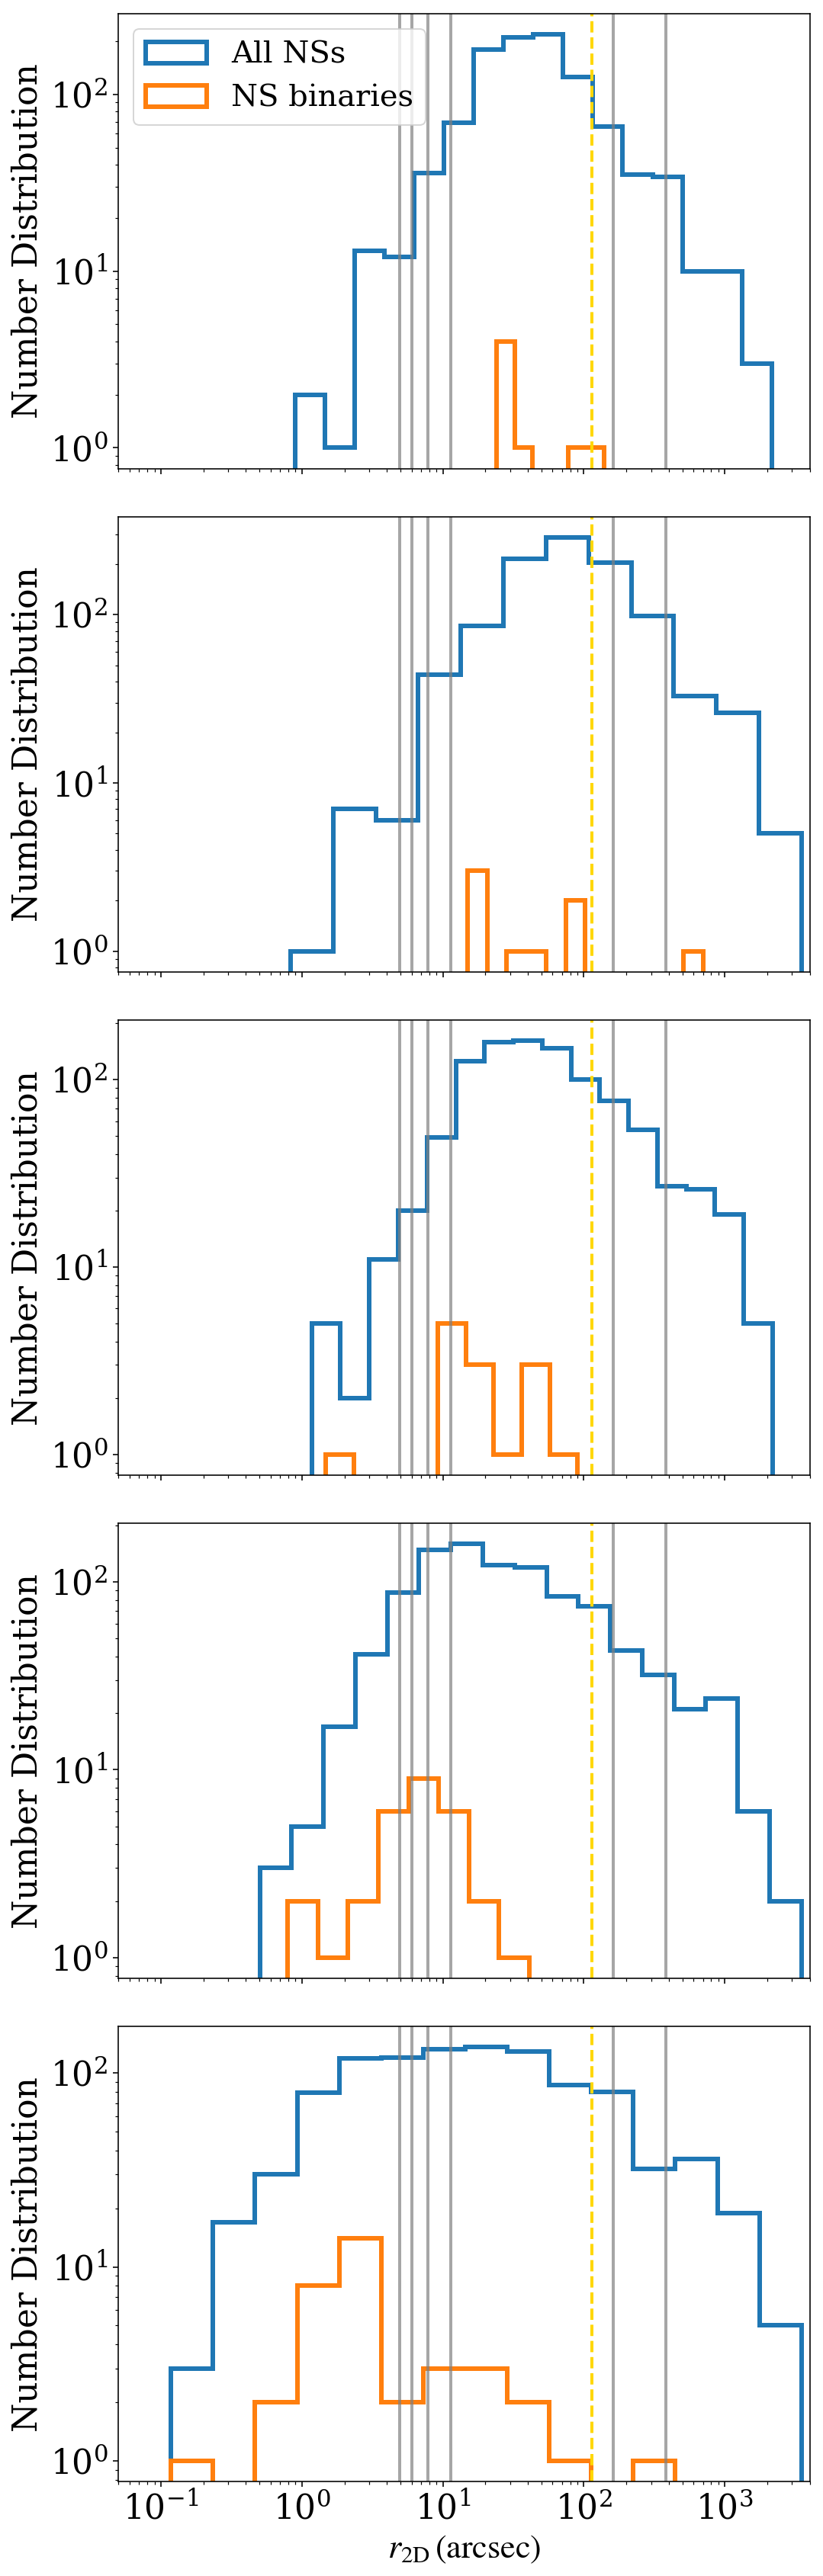

In [6]:
##Radial distribution of MSPs and NS binaries as a function of time
d6752 = 4.125 ##kpc

t_steps = [100., 1000., 5000., 7500., 10000.]

t_conv = dyn.conv('t', paths[0]+'initial.conv.sh')
snap2d_unsort=np.array(glob(paths[0]+'*.snap*.2Dproj.dat.gz'))
snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
#snap2d = snap2d_unsort[snap2dno.argsort()]
snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
print(snap2dno)
#print(snap2d)
print(ns.get_time(snap2d[-1]))
    
fig, axs = plt.subplots(nrows = 5, figsize=(8, 24), sharex=True)
for hh in range(len(t_steps)):
    rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
    rpc_nsbin = []
    id_2dmsp = []
    n_nonmsp_sin = 0; n_msp_sin = 0
    for xx in range(len(snap2d)):
        if os.stat(snap2d[xx]).st_size==0:
            continue
        if ns.get_time(snap2d[xx])>=t_steps[hh]:
            print(ns.get_time(snap2d[xx]))
        
            with gzip.open(snap2d[xx], 'r') as f2d:
                    next(f2d); next(f2d)
                    for line in f2d:
                        data2d = line.split()
                        if int(data2d[2]) == 1:
                            if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                rpc_nsbin.append(float(data2d[0]))
                                #if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                    #rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    #if float(data2d[13]) in id_msp:
                                    #    id_2dmsp.append(int(data2d[13]))
                                    #if float(data2d[14]) in id_msp:
                                    #    id_2dmsp.append(int(data2d[14]))
                                #else:
                                    #mtot_nonmsp.append(float(data2d[9]))
                                    
                        else:
                            if int(data2d[3]) == 13: 
                                rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                #if float(data2d[12]) in id_msp:
                                #    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                #    id_2dmsp.append(int(data2d[12]))
                                #    n_msp_sin+=1
                                #else:
                                #    mtot_nonmsp.append(float(data2d[9]))
                                #    n_nonmsp_sin+=1
                                
            r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60*60
            #r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
            r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60*60
            
            
            axs[hh].hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 18), 
                     cumulative = False, density = False, histtype = 'step', lw = 3., label = 'All NSs')
            axs[hh].hist(r_proj_nsbin, bins = np.logspace(np.log10(min(r_proj_nsbin)), np.log10(3500), 18), 
                     cumulative = False, density = False, histtype = 'step', lw = 3., label = 'NS binaries')
            #axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
            #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'MSPs')
            [axs[hh].axvline(_x, lw = 2., color = 'gray', alpha=0.7) for _x in psroffsets]
            axs[hh].axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
            axs[hh].set_xscale('log')
            axs[hh].set_yscale('log')
            axs[hh].set_xlim(xmin = 0.05, xmax = 4000.)
            axs[hh].set_ylabel('Number Distribution')
            #axs[hh].text(0.05, 10, 't='+str(int(t_steps[hh]))+' Myr', fontsize=20)
            break

            
axs[-1].set_xlabel(r'$r_{\rm{2D}}\,(\rm{arcsec})$')
axs[0].legend(loc = 'upper left', fontsize = 20)
fig.subplots_adjust(wspace = 0.05)
fig.tight_layout()

(161, 326, 501, 503, 505, 507, 509, 511, 513, 515, 517, 519, 521, 522, 523, 525, 527, 529, 531, 533, 535, 537, 539, 541, 543, 545, 547, 549, 551, 553, 555, 557, 559, 561, 563, 565, 567, 569, 571, 573, 575, 577, 579, 581, 583, 585, 587, 589, 591, 593, 595, 597, 599, 601, 603, 605, 607, 609)
13477.9
100.495
952 1
11952.9
779 13
(34, 152, 358, 360, 361, 362, 364, 366, 368, 370, 371, 372, 374, 376, 378, 380, 381, 382, 384, 386, 388, 390, 391, 392, 394, 396)
14000.0
100.263
869 1
11913.1
774 2
(9, 99, 270, 272, 274, 276, 278, 279, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310)
14000.1
102.032
576 1
12130.1
494 2


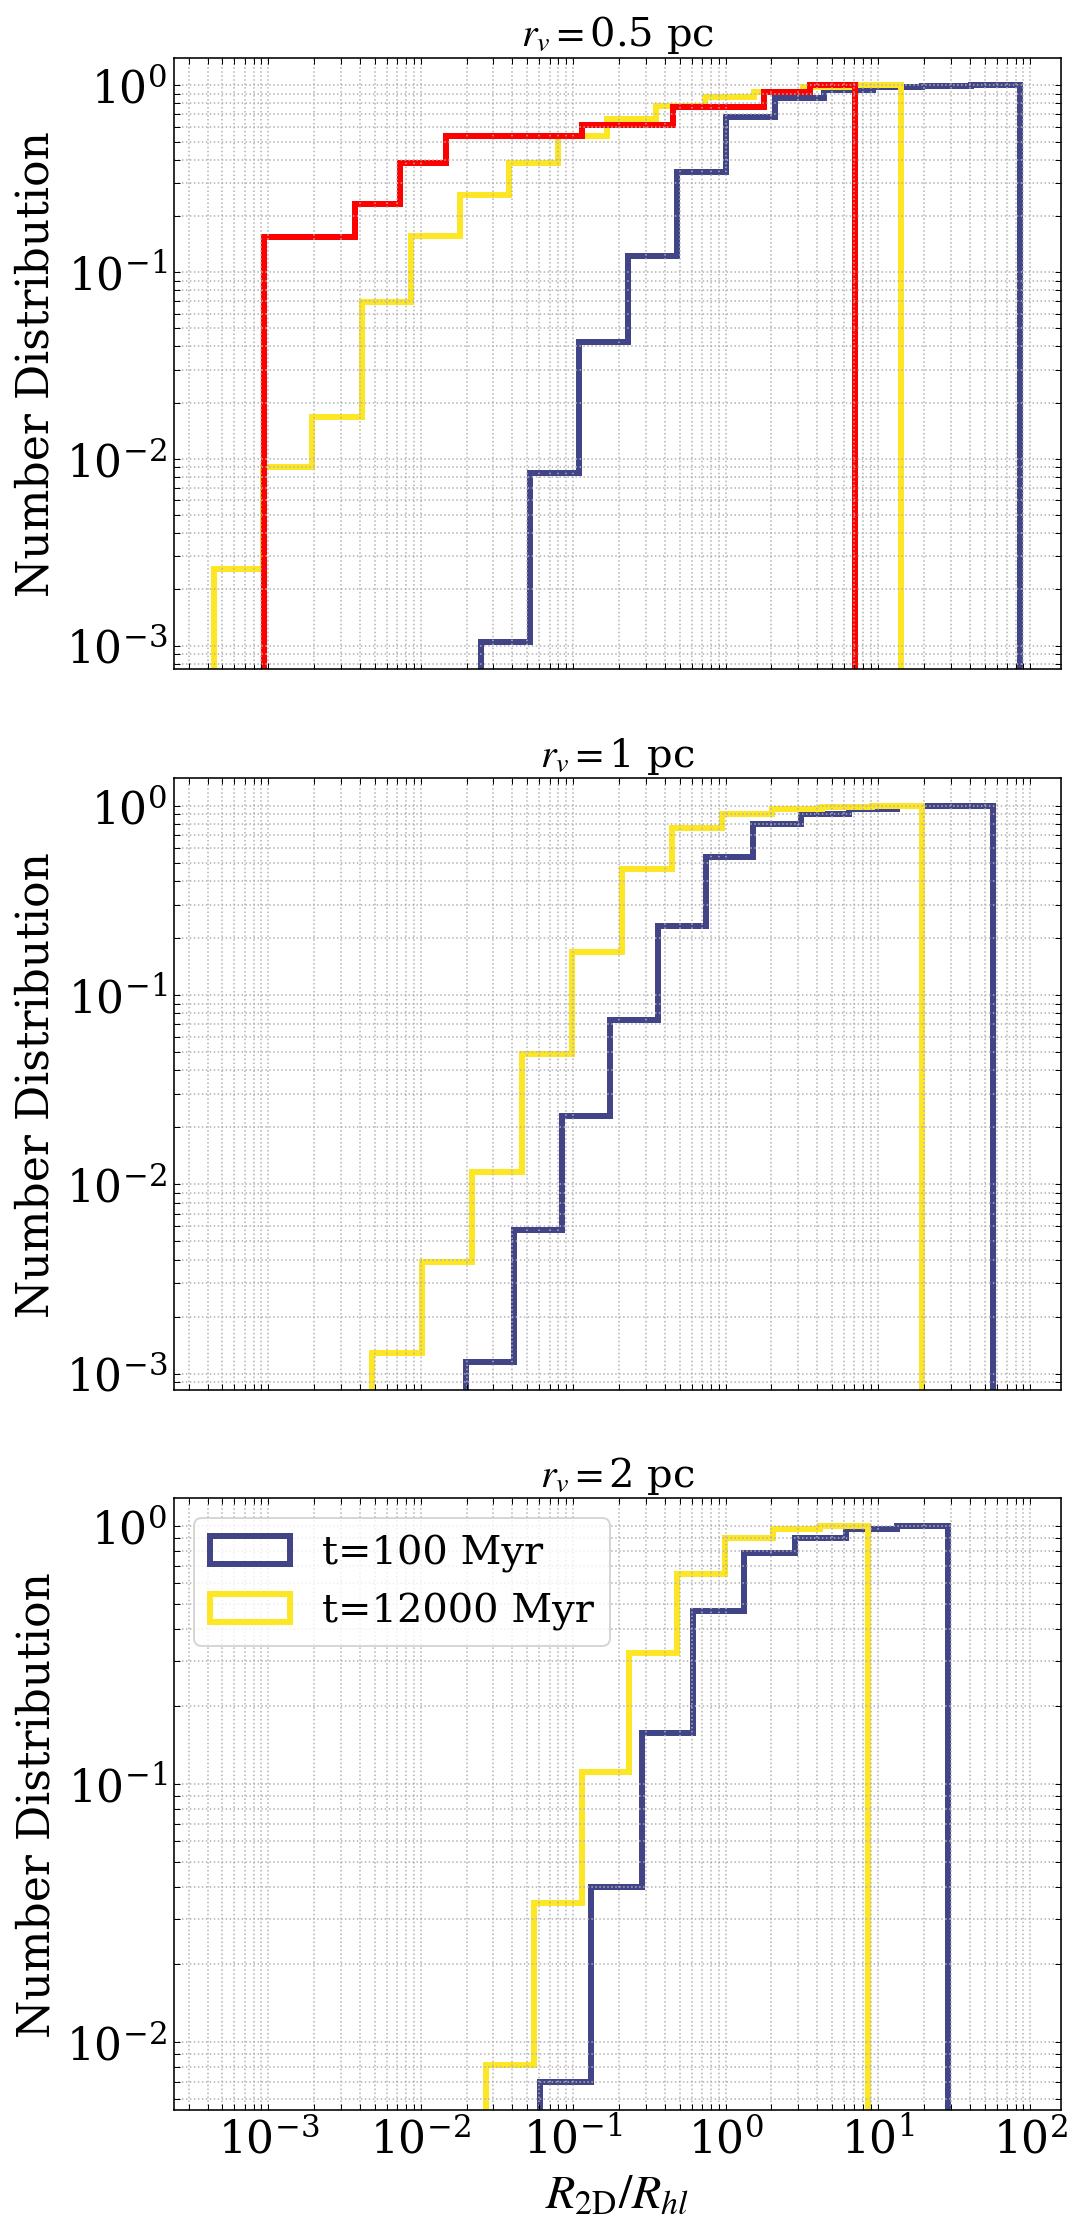

In [10]:
##Radial distribution of MSPs and NS binaries as a function of time
##Comparing CC and Noncc cluster
d6752 = 4.125 ##kpc

path2 = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/', 
         '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/8e5/',
         '/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.0002/8e5/']
         #['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/8e5/',
         #'/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.002/8e5/',
         #'/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg20/z0.002/8e5/']]

t_steps = [100., 11900.]
t_labels = [100., 12000.]
cs1 =  cm.viridis(np.linspace(0.2, 1, 2))
cs2 =  cm.autumn(np.linspace(0.2, 1, 2))
bin_sizes = [[12,15], [12,12], [9,9]]

rvs = [0.5, 1, 2]

fig, axs = plt.subplots(nrows = 3, figsize=(8, 16), sharex=True)
for ii in range(len(path2)):
    t_conv = dyn.conv('t', path2[ii]+'initial.conv.sh')
    snap2d_unsort=np.array(glob(path2[ii]+'*.snap*.2Dproj.dat.gz'))
    snap2dno_unsort = [int((x.split('.')[-4]).split('p')[1]) for x in snap2d_unsort]
    #snap2d = snap2d_unsort[snap2dno.argsort()]
    snap2dno, snap2d = zip(*sorted(zip(snap2dno_unsort,snap2d_unsort)))
    print(snap2dno)
    #print(snap2d)
    print(ns.get_time(snap2d[-1]))
    
    clus_param = np.sort(glob(path2[ii]+'initial.snap*.cluster_params.dat'))
    #print(clus_param)
    
    for hh in range(len(t_steps)):
        rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
        rpc_nsbin = []
        id_2dmsp = []
        n_nonmsp_sin = 0; n_msp_sin = 0
        for xx in range(len(snap2d)):
            if os.stat(snap2d[xx]).st_size==0:
                continue
            if ns.get_time(snap2d[xx])>=t_steps[hh]:
                print(ns.get_time(snap2d[xx]))
                
                data_param = np.genfromtxt(clus_param[xx])
                r_hl = data_param[0][10]
            
                with gzip.open(snap2d[xx], 'r') as f2d:
                        next(f2d); next(f2d)
                        for line in f2d:
                            data2d = line.split()
                            if int(data2d[2]) == 1:
                                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                    rpc_nsbin.append(float(data2d[0]))
                                    #if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                                        #rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                        #if float(data2d[13]) in id_msp:
                                        #    id_2dmsp.append(int(data2d[13]))
                                        #if float(data2d[14]) in id_msp:
                                        #    id_2dmsp.append(int(data2d[14]))
                                    #else:
                                        #mtot_nonmsp.append(float(data2d[9]))
                                        
                            else:
                                if int(data2d[3]) == 13: 
                                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                                    #if float(data2d[12]) in id_msp:
                                    #    rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                                    #    id_2dmsp.append(int(data2d[12]))
                                    #    n_msp_sin+=1
                                    #else:
                                    #    mtot_nonmsp.append(float(data2d[9]))
                                    #    n_nonmsp_sin+=1
                                    
                r_proj = np.array(rpc)/r_hl#/(d6752*1000.)*180/np.pi*60*60
                #r_proj_msp = np.array(rpc_msp)/(d6752*1000.)*180/np.pi*60*60
                r_proj_nsbin = np.array(rpc_nsbin)/r_hl#/(d6752*1000.)*180/np.pi*60*60
                print(len(r_proj), len(r_proj_nsbin))
                
                axs[ii].hist(r_proj, bins = np.logspace(np.log10(np.min(r_proj)), np.log10(np.max(r_proj)), bin_sizes[ii][hh]), 
                             cumulative = True, density = True, histtype = 'step', lw = 3., 
                             label = 't='+str(int(t_labels[hh]))+' Myr',
                             color = cs1[hh])
                if len(r_proj_nsbin)>5:
                    axs[ii].hist(r_proj_nsbin, bins = np.logspace(np.log10(np.min(r_proj_nsbin)), np.log10(np.max(r_proj_nsbin)), 14), 
                                 cumulative = True, density = True, histtype = 'step', lw = 3., label = 'NS binaries',
                                 color = 'red')
                #axs.hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
                #         cumulative = False, density = False, histtype = 'step', lw = 3., label = 'MSPs')
                #[axs[ii].axvline(_x, lw = 2., color = 'gray', alpha=0.7) for _x in psroffsets]
                #axs[ii].axvline(x=1.91*60., lw = 2., color = 'gold', ls='--')
                axs[ii].set_xscale('log')
                axs[ii].set_yscale('log')
                #axs[ii].set_xlim(xmin = 0.005, xmax = 4000.)
                axs[ii].set_ylabel('Number Distribution')
                axs[ii].set_title(r'$r_v=$'+str(rvs[ii])+' pc', fontsize=20)
                
                axs[ii].grid(linestyle=':',which='major',linewidth='0.75')
                axs[ii].grid(linestyle=':',which='minor',linewidth='0.75')
                axs[ii].xaxis.set_ticks_position('both')
                axs[ii].yaxis.set_ticks_position('both')
                axs[ii].tick_params('both',length=3,width=0.5,which='both',direction = 'in')
                break
    

axs[-1].set_xlabel(r'$R_{\rm{2D}}/R_{hl}$', fontsize=24)
axs[2].legend(loc = 'upper left', fontsize = 20)
fig.tight_layout()
#fig.subplots_adjust(vspace = 0.01)
plt.savefig(savepath+'offset_comparison.pdf', dpi=300)

In [12]:
print(1.29/(4.125*1000.)*180/np.pi*60*60)

64.50463031727378


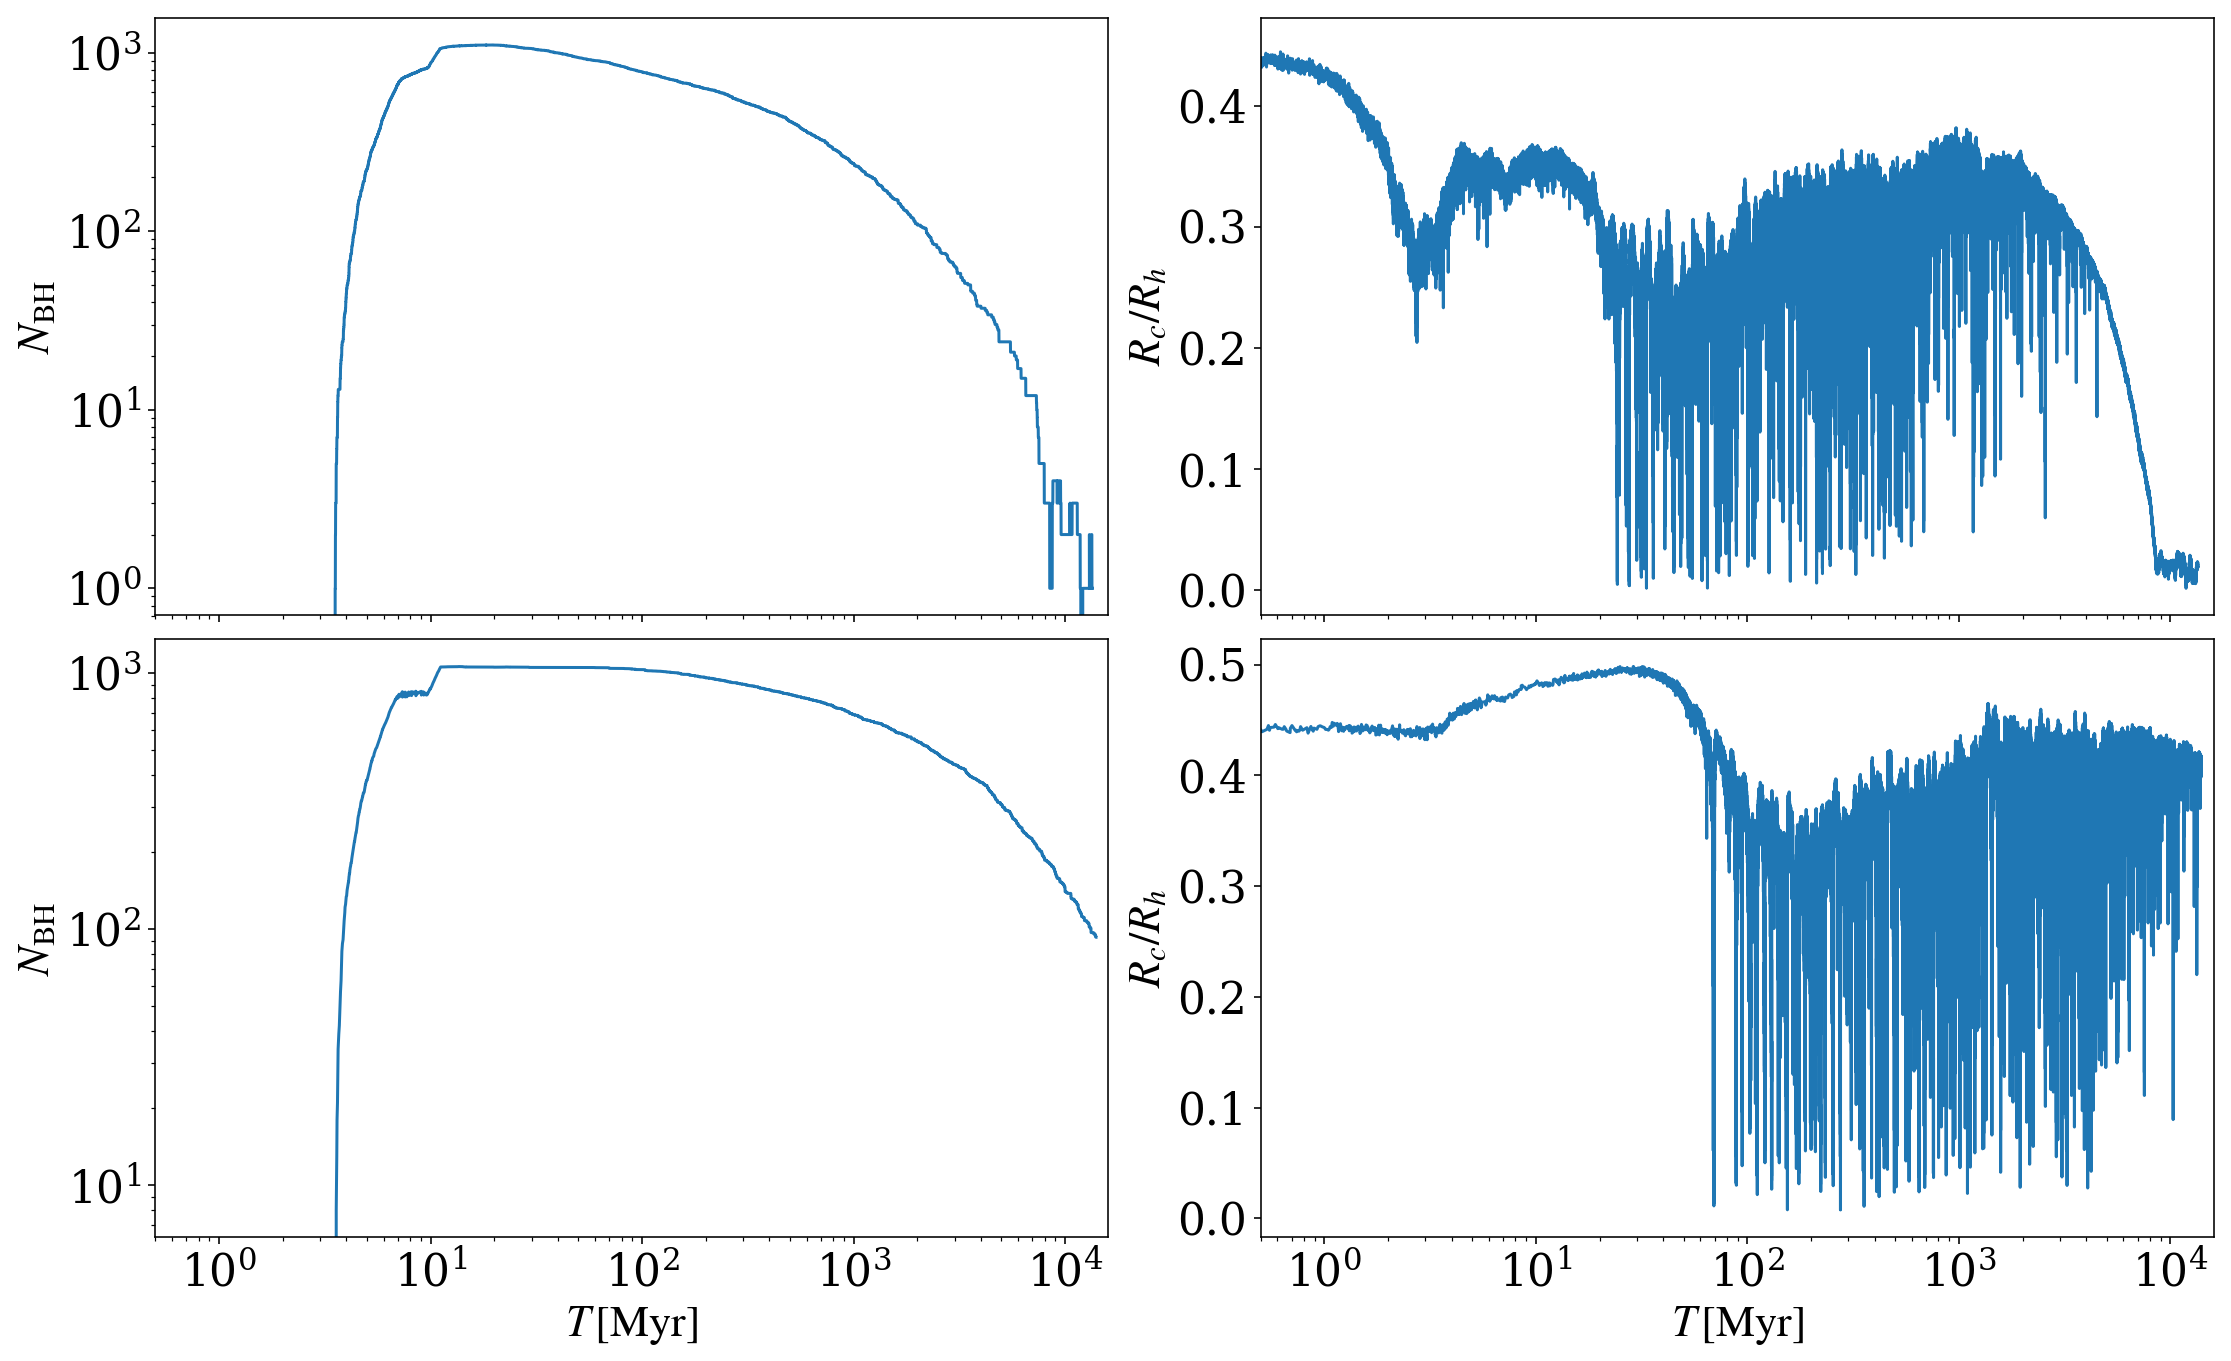

In [21]:
##Rc/Rh, Number of BHs and Cluster density as a function of time to check core-collapse
path2 = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/',
         '/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.0002/8e5/']

fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(16, 10), sharex=True, sharey=False)
for xx in range(len(path2)):
    t_conv = dyn.conv('t', path2[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', path2[xx]+'initial.conv.sh')

    bhfile = np.genfromtxt(path2[xx]+'initial.bh.dat')
    tbh = bhfile[:,1]*t_conv; Nbh = bhfile[:,2]
    
    dynfile = np.genfromtxt(path2[xx]+'initial.dyn.dat')
    tdyn = dynfile[:,0]*t_conv; Rc = dynfile[:,7]*l_conv; Rh = dynfile[:,20]*l_conv
    Nc = dynfile[:,6]; rho_c = Nc/(2*twopi/3.)/Rc**3
    
    axs[xx][1].plot(tdyn, Rc/Rh)
    axs[xx][1].set_xscale('log')
    axs[xx][1].set_xlim(xmin=0.5, xmax=16000.)
    
    #axs[1].plot(tdyn, rho_c)
    #axs[1].set_yscale('log')
    #axs[1].set_xscale('log')
    #axs[1].set_ylabel(r'$\rho_c\,[\rm{pc^{-3}}]$')
    #axs[1].set_xlim(xmin=0.01, xmax=16000.)
    
    axs[xx][0].plot(tbh, Nbh)
    axs[xx][0].set_xscale('log')
    axs[xx][0].set_xlim(xmin=0.5, xmax=16000.)
    axs[xx][0].set_yscale('log')
    
    axs[xx][0].set_ylabel(r'$N_{\rm{BH}}$')
    axs[xx][1].set_ylabel(r'$R_c/R_h$')
    axs[1][xx].set_xlabel(r'$T\,[\rm{Myr}]$') 


fig.tight_layout()
plt.subplots_adjust(hspace=0.04, wspace=0.16)
plt.savefig(savepath+'nbh_rcrh.pdf', dpi=300)

280
141 ['104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '104', '1851', '5272', '5272', '5904', '5904', '5904', '6121', '6205', '6205', '6205', '6205', '6205', '6205', '6266', '6266', '6266', '6266', '6266', '6266', '6342', '6397', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '6440', '6440', '6440', '6440', '6440', '6440', '6440', '6440', '6441', '6441', '6441', '6441', '6517', '6517', '6517', '6517', '6522', '6539', '6544', '6544', '6624', '6624', '6624', '6624', '6624', '6624', '6624', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6626', '6652', '6656', '6656', '6752', '6752', '6752', '6752', '6752', '6752', '6760', '6760', '6838', '7078', '7078', '7078', '7078', '7078', '7078', '7078', '7078', '7099', '7099

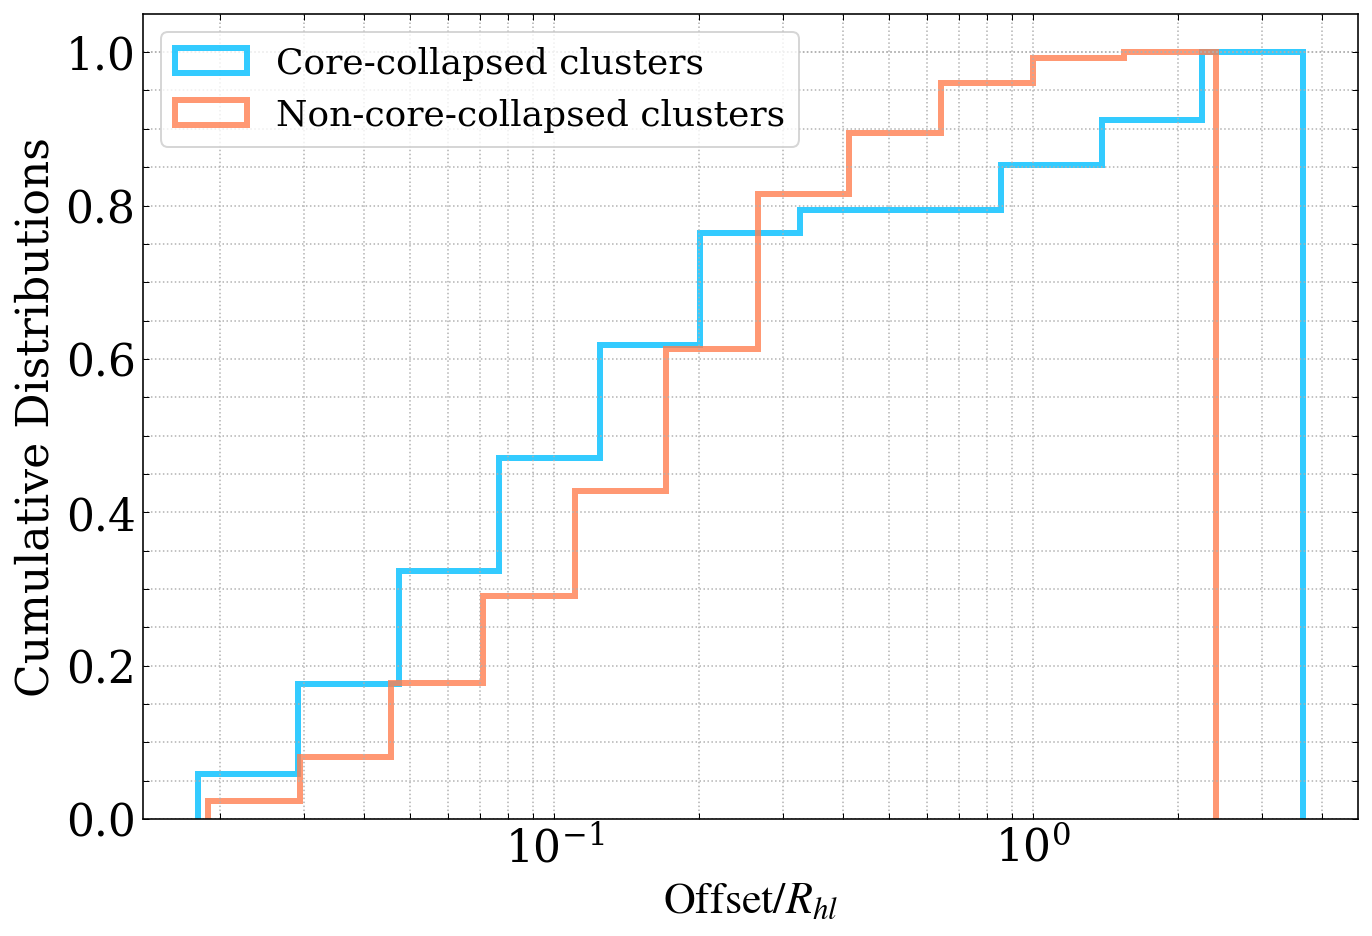

In [2]:
####Offset Distributions
Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire(spinflag=0,offsetflag=1)
print(len(Clusoff), Clusoff)
print(np.max(Offset))
Offset=np.array(Offset); Binoff = np.array(Binoff)
Poff = np.array(Poff); Clusoff = np.array(Clusoff)
#Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]
print(Offset, Clusoff)

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
print(len(rc_psrcat))
CCst = np.array(data_gcmsp['cc'])
print(CCst)
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

Rcoff = []; Rhloff = []; CCs = []
for kk in range(len(Clusoff)):
    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0])
    CCs.append(CCst[clusno==Clusoff[kk]][0]) 
Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)
CCs = np.array(CCs)
print(Rhloff, Clusoff)


ccoffrhl = (Offset/Rhloff)[CCs==1]
nonccoffrhl = (Offset/Rhloff)[CCs==0]
nobs_cc = len(ccoffrhl)
nobs_noncc = len(nonccoffrhl)
print(nobs_cc, nobs_noncc)

#########################################################################
##Adding Omega Cen from https://ui.adsabs.harvard.edu/abs/2023MNRAS.520.3847C/abstract
ra_psr_oc = ['13:26:39.7','13:26:49.7','13:26:55.5','13:26:32.5','13:26:42.6',
             '13:26:53','13:26:37.1','13:26:44','13:26:29.0','13:26:51.7',
             '13:26:38.1','13:27:02.8','13:26:59','13:26:49.8','13:26:48',
             '13:26:45', '13:26:35','13:27:10'] 
decl_psr_oc = ['-47:30:11','-47:29:26','-47:30:13','-47:28:39','-47:27:22',
               '-47:28:28','-47:29:41','-47:28:55','-47:30:24','-47:27:09',
               '-47:27:39','-47:26:49','-47:30:09','-47:31:25','-47:27:19',
               '-47:29:42','-47:27:54','-47:29:02']
ra_oc = np.full_like(ra_psr_oc, '13:26:47.24')
decl_oc = np.full_like(ra_psr_oc, '−47:28:46.5')

from astropy.coordinates import SkyCoord
from astropy import units as u
def cal_offsets(ra_cen, decl_cen, ra_psr, decl_psr):
    allsep = []
    for xx in range(len(ra_cen)):
        c1 = SkyCoord(ra_cen[xx], decl_cen[xx], unit=(u.hourangle, u.deg))
        c2 = SkyCoord(ra_psr[xx], decl_psr[xx], unit=(u.hourangle, u.deg))
        sep = c1.separation(c2)
        allsep.append(sep.arcminute)
    return np.array(allsep)

offset_oc = cal_offsets(ra_oc, decl_oc, ra_psr_oc, decl_psr_oc)

rhl_oc = 5.00

nonccoffrhl = np.concatenate((nonccoffrhl, np.array(offset_oc)/rhl_oc))
##################################################################
print(stats.ks_2samp(ccoffrhl, nonccoffrhl))
res = stats.anderson_ksamp([ccoffrhl,nonccoffrhl])
print(res)

####Plotting
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(ccoffrhl,# bins=10,
        bins = np.logspace(np.log10(np.min(ccoffrhl)), np.log10(np.max(ccoffrhl)), 12),
        cumulative=True, density=True,# stacked=True,
        #density=True,
        histtype='step', label = 'Core-collapsed clusters', lw=3, color='deepskyblue', alpha=0.8)
ax.hist(nonccoffrhl,# bins=10,
        bins = np.logspace(np.log10(np.min(nonccoffrhl)), np.log10(np.max(nonccoffrhl)), 12),
        cumulative=True, density=True,# stacked=True,
        #density=True,
        histtype='step', label = 'Non-core-collapsed clusters', lw=3, color='coral', alpha=0.8)


ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Offset}/\mathit{R_{hl}}$')
ax.set_ylabel('Cumulative Distributions')
ax.legend(loc='upper left', fontsize=18)
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

fig.tight_layout()
plt.savefig(savepath+'observed_offset_cc_noncc+omegacen.pdf', dpi=300)

[0.00000000e+00 1.00010001e+00 2.00020002e+00 ... 9.99799980e+03
 9.99899990e+03 1.00000000e+04]
[0.         0.01206161 0.02309613 ... 3.99760124 3.99780137 3.9980015 ]
[ 0.          8.11246222 14.87273472 ... 89.13981428 89.13982319
 89.13983209]


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log10


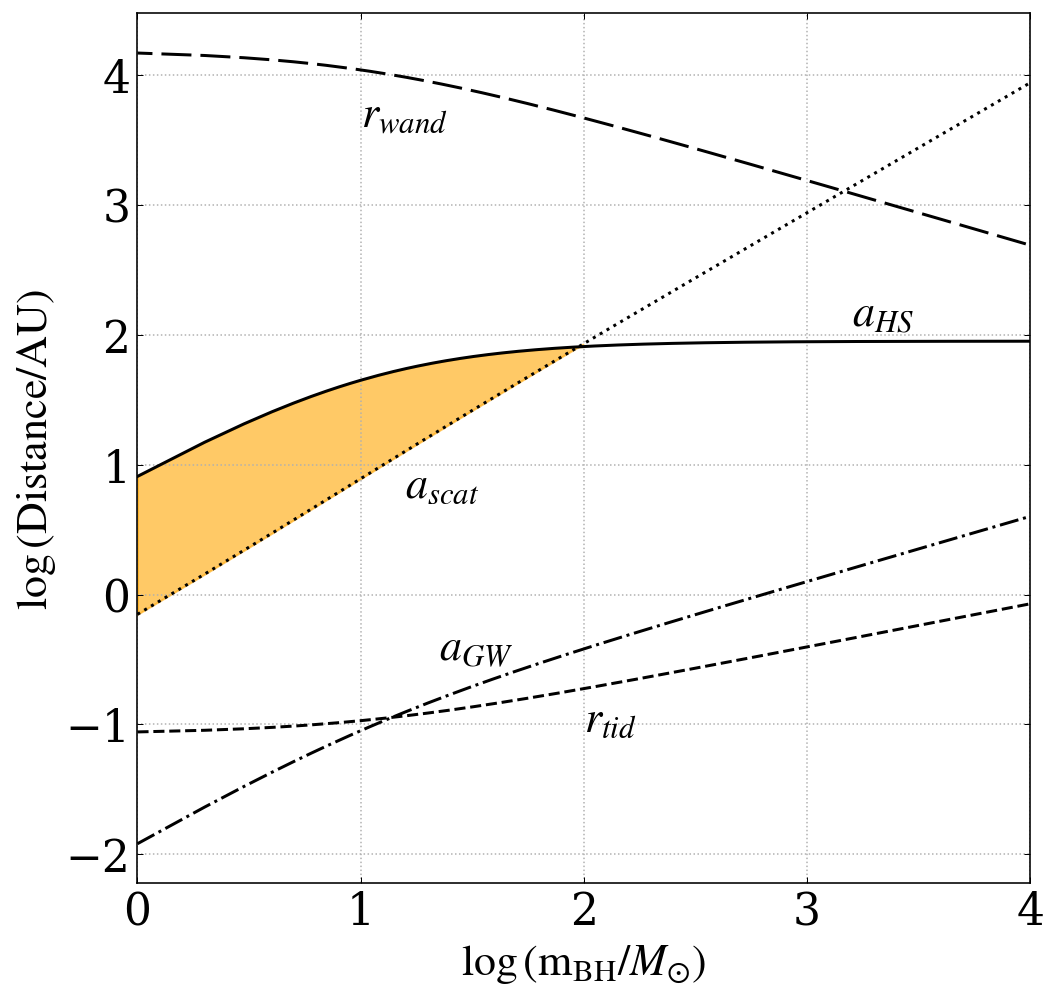

In [8]:
##Remaking Figure 1 in the paper
M_bh1=10.0
m_bh2=np.linspace(0,10000.0,num=10000)
print(m_bh2)
mu_bh=M_bh1*m_bh2/(M_bh1+m_bh2)
M_bht=M_bh1+m_bh2
tau_gw=10.0**10.0
ma=1.5
mb=0.6


# All in AU:
a_gw=0.4*(M_bht/100.0)**0.5*(mu_bh/10.0)*(tau_gw/(10.0**10.0))
print(a_gw)

#This is from Merritt (2013) for a single IMBH, but is valid to within a factor of two for a binary IMBH-BH as well:
a_wand=0.03*(M_bht/10.0**3.0)**(-0.5)*(5.0/20.0)/(4.8481*10.0**(-6.0))
v_ej=35.0
a_scat=mu_bh/10.0*(35.0/v_ej)
r_tid=0.2*(M_bht/100.0*1.6/(ma+mb))**(1.0/3.0)
G=6.678*10.0**(-11.0)
Es=0.5*(M_bh1+m_bh2)*(ma+mb)/(M_bh1+m_bh2+mb+ma)*(5000.0)**2.0
#	-G*ma*mb/(2.0*a)
a_rec=G*(M_bh1*m_bh2)*(1.9989*10.0**30.0)**1.0/(-2.0*Es+35000.0**2.0*(2.0**2.0*(M_bh1+m_bh2)*(ma+mb)/(M_bh1+m_bh2-ma-mb)))
a_rec=a_rec/(1.496*10.0**11.0)


mbh_imbh=np.linspace(0,10000.0,num=10000)
#G=6.678*10.0**(-11.0)
rm=G*(mbh_imbh*1.9989*10.0**30.0)/(5.0*1000.0)**2.0
a_hs=10.0/(mbh_imbh+10.0)*rm/4.0
a_hs=a_hs/(1.496*10.0**11.0)
print(a_hs)

log_a_gw=np.log10(a_gw)
log_a_scat=np.log10(a_scat)
log_r_tid=np.log10(r_tid)
log_a_wand=np.log10(a_wand)
log_ahs=np.log10(a_hs)
log_arec=np.log10(a_rec)


log_mbh2=np.log10(m_bh2)
log_mbh_imbh=np.log10(mbh_imbh)

fig, axs = plt.subplots(figsize=(8,8))
axs.plot(log_mbh_imbh, log_ahs, c='k')
axs.text(3.2, 2.07, '$a_{HS}$')
axs.plot(log_mbh2, log_a_wand, ls=(5,(10,3)), c='k')
axs.text(1,3.6, '$r_{wand}$')
axs.plot(log_mbh2, log_a_gw, ls='dashdot', c='k')
axs.text(1.35, -0.5, '$a_{GW}$')
axs.plot(log_mbh2, log_arec, ls='dotted', c='k')
axs.text(1.2, 0.75, '$a_{scat}$')
axs.plot(log_mbh2, log_r_tid, ls='--', c='k')
axs.text(2.0, -1.05, '$r_{tid}$')
axs.fill_between(log_mbh2[log_mbh2<=2.], log_arec[log_mbh2<=2.], log_ahs[log_mbh2<=2.], 
                alpha=0.6, color='orange')


axs.set_xlim(xmin=0, xmax=4)
axs.set_xlabel(r'$\rm{log}\,(m_{\rm{BH}}/\mathit{M_{\odot}})$')
axs.set_ylabel(r'$\rm{log\,(Distance/AU)}$')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig(savepath+'remake_figure1.pdf', dpi=300)


#       	expand 1.05
#	limits 0 4.0 -2.5 4.5
##      	limits 0 4.0 -2 4
#       	box
#       	ltype 0
#	lweight 5
#	ltype 5
#     	connect log_mbh2 log_a_gw
#       	ltype 1
##       	connect log_mbh2 log_a_scat
#	connect log_mbh2 log_arec
#	ltype 2
#       	connect log_mbh2 log_r_tid
#	ltype 3
#	connect log_mbh2 log_a_wand
#	ltype 0
#	connect log_mbh_imbh log_ahs
#	ctype default


#lweight 2.5
#relocate 1.35 -0.5
#label a_{GW}
#relocate 1.2 0.83
#label a_{scat}
#relocate 2.0 -1.05
#label r_{tid}
#relocate 1 3.7
#label r_{wand}
#relocate 3.2 2.07
#label a_{HS}

#lweight 1
#ltype 0
#   	expand 1.5
#   	xlabel log (m_{BH}/M_{\odot})
#   	ylabel log (Distance/AU)

#ltype 0
       

In [8]:
##Calculate the inspiral time of a BH
import scipy.special as ss

def T_df(Rpc, Mbh, Mclu, apc, gamma):
    rho_0 = Mclu/apc**3*ss.gamma((gamma+1)/2.)/(3./2.*ss.gamma((gamma-2)/2.))
    #print('rho_0', rho_0)
    beta = Rpc**2/apc**2
    A = ss.hyp2f1(3./2., (gamma+1)/2., 5./2., -beta)
    B = ss.hyp2f1(1./2., (gamma-1)/2., 3./2., -beta)
    C = ss.hyp2f1(5./2., (gamma+3)/2., 7./2., -beta)
    
    vc = (Gconst_sun*2.*twopi/3.*rho_0*Rpc**2*A)**0.5
    sigma_v = 6 #km/s
    Xc = vc/math.sqrt(2)/sigma_v
    chi = math.erf(Xc)-2*Xc/math.sqrt(np.pi)*math.exp(-Xc**2)
    
    coulomb = 5
    
    One = 2*beta*apc**2*(Gconst_sun*2.*twopi/3.*rho_0*A)**0.5*(A/3.-(gamma+1)/20.*beta*C)*Rpc
    Two = coulomb*chi*Gconst_sun*(1+beta)**(-(gamma+1)/2.)*Mbh
    
    Tdf = One/Two*(PC/10**5)/yearsc/10**9
    
    return Tdf

print(T_df(5, 1.4, 2.48062e+06, 4., 2.1))
print(T_df(3, 1.4, 1.0e+06, 4., 3))

f = lambda x: T_df(x, 40, 2.48062e+06, 4., 2.1)
print(scipy.integrate.quad(f, 0, 30))
    

10.519773784850264
5.075504886704083
(224.85751242156425, 4.750901495070251e-07)


/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/
11054.52569672
476
11247.982754360002
479
11492.75262108
482
11678.87079372
485
11984.68128812
488
11984.68128812
12200.5200892
491
12415.368900000001
494
12684.630060000001
497
13021.5236848
500
13194.21794016
503
13474.520157400002
506
13703.84361136
509
13800.02855656
512
1.2338857563755647


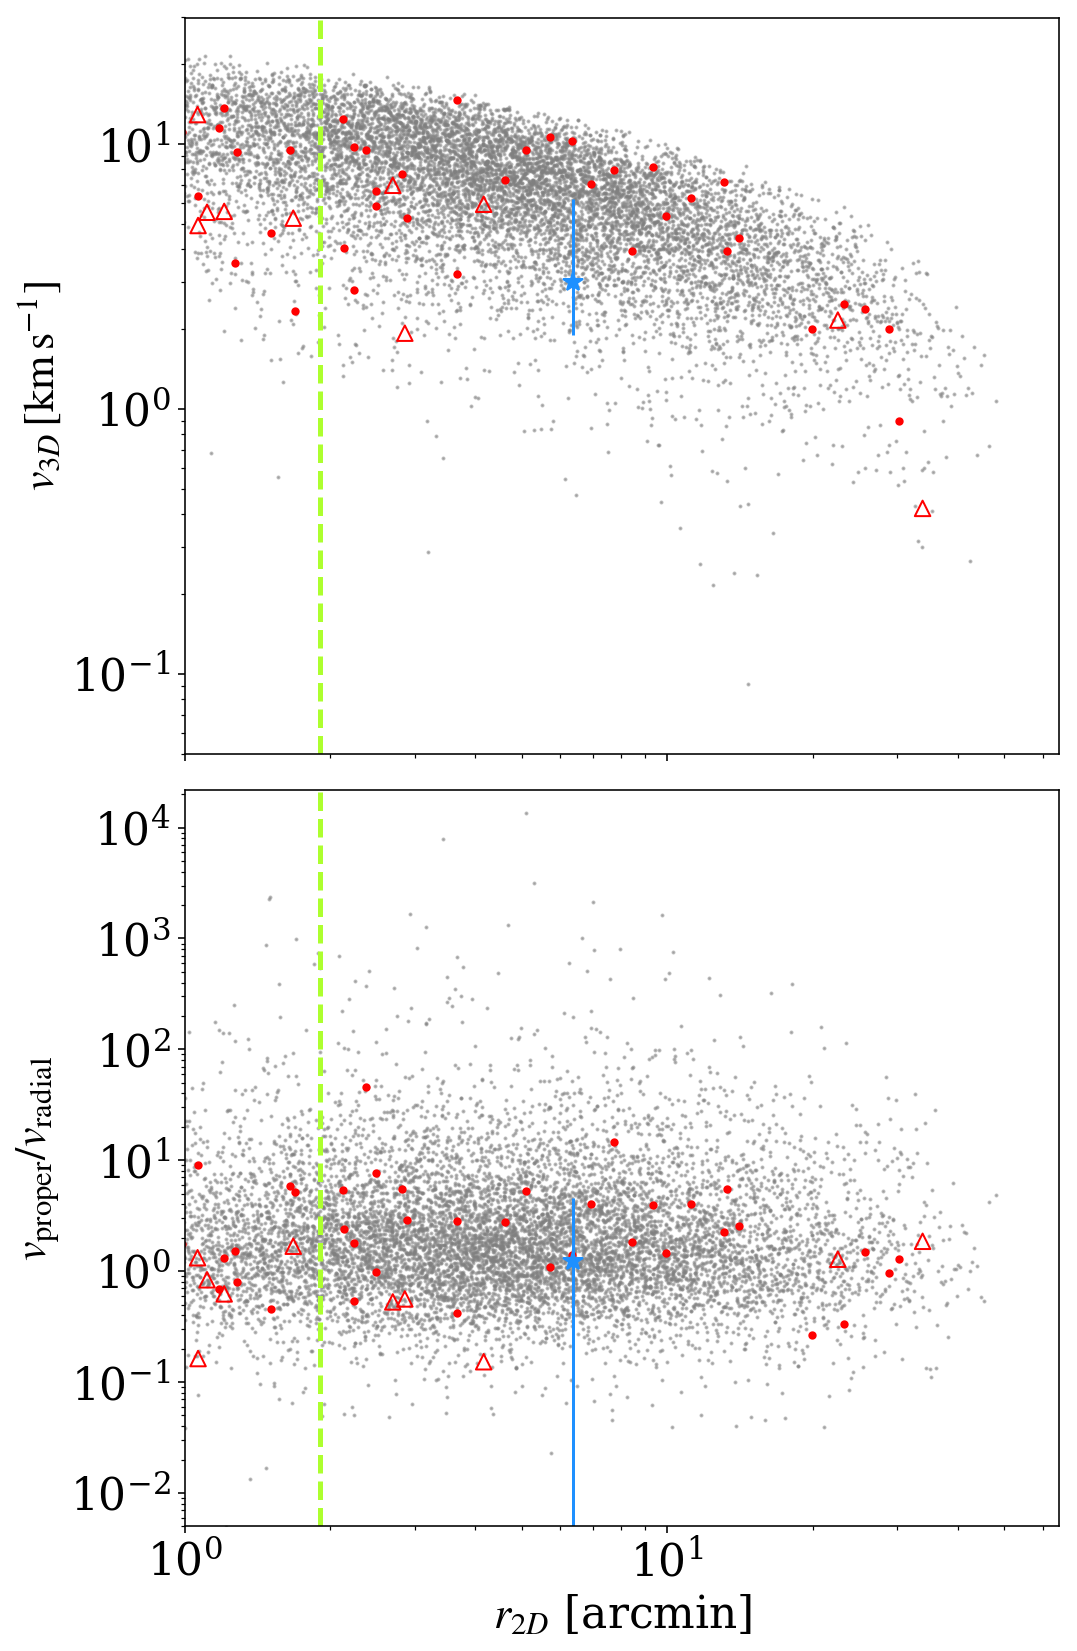

In [9]:
##Velocities of outskirt NS binaries

def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)

##Fiducial model
d6752 = 3.98 ##kpc from https://doi.org/10.1051/0004-6361/202244418
vel_psrA_masyr = [-0.069,  0.097]; err_psrA_masyr = [0.03,  0.037]
pm = (vel_psrA_masyr[0]**2+vel_psrA_masyr[1]**2)**0.5
err_pm = err_sigma(pm, 1, 1, vel_psrA_masyr[0], vel_psrA_masyr[1], err_psrA_masyr[0], err_psrA_masyr[1])
pm_kms = uc.pm2vel(d6752, pm)
err_pm_kms = uc.pm2vel(d6752, err_pm)
los_kms = -1.82
err_los_kms = 4.9
err_tr_ratio = err_ratio(pm_kms/los_kms, pm_kms, los_kms, err_pm_kms, err_los_kms)

##Cumulative radial distribution
path_6752 = paths[0]#'/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'
print(path_6752)

snap2d = np.sort(glob(path_6752+'initial.snap*.2Dproj.dat.gz'))
clus_param = np.sort(glob(path_6752+'initial.snap*.cluster_params.dat'))

rpc_nsbin = []
type_nsbin = []
vx_nsbin = []; vy_nsbin = []; vz_nsbin = []
for yy in range(len(clus_param)):
    data_param = np.genfromtxt(clus_param[yy])
    if os.stat(clus_param[yy]).st_size==0:
        continue
    if data_param[0][0]<11000.: continue
    if data_param[0][0]>14000.: break
        
    rpc = [] #rpc_ns[]; rpc_msp = []; rpc_nsbin = []
    r_type = []
    vx = []; vy = []; vz = []
        
    print(data_param[0][0])
    thesnapno = int(snap2d[yy].split('.')[-4][4:])
    print(thesnapno)

     
    ##Now extract data from multiple snapshots
    datamsp = np.genfromtxt(path_6752+'MSP'+str(thesnapno)+'.dat')
    id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]
    
    with gzip.open(path_6752+'initial.snap'+str(thesnapno)+'.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data2d = line.split()
                
            rpc.append(float(data2d[0]))
            vx.append(float(data2d[18]))
            vy.append(float(data2d[19]))
            vz.append(float(data2d[20]))
            
            r_type.append('all')
            
            if int(data2d[2]) == 1:
                r_type[-1]='bin'
                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                    #rpc_nsbin.append(float(data2d[0]))  
                    r_type[-1] = 'nsbin'
                    if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                        r_type[-1]='mspbin'

            else:
                if int(data2d[3]) == 13: 
                    r_type[-1]='ns'
                    if float(data2d[12]) in id_msp:
                        r_type[-1]='msp'
    
    rpc = np.array(rpc)
    r_type = np.array(r_type)
    vx = np.array(vx); vy = np.array(vy); vz = np.array(vz)
    
    rpc_nsbin = rpc_nsbin+list(rpc[r_type == 'nsbin'])+list(rpc[r_type == 'mspbin'])
    type_nsbin = type_nsbin+list(r_type[r_type == 'nsbin'])+list(r_type[r_type == 'mspbin'])
    vx_nsbin = vx_nsbin+list(vx[r_type == 'nsbin'])+list(vx[r_type == 'mspbin'])
    vy_nsbin = vy_nsbin+list(vy[r_type == 'nsbin'])+list(vy[r_type == 'mspbin'])
    vz_nsbin = vz_nsbin+list(vz[r_type == 'nsbin'])+list(vz[r_type == 'mspbin'])
    
                            
    if data_param[0][0]>11900. and data_param[0][0]<12200.:
        rpc_12 = rpc
        r_type_12 = r_type
        vx_12 = vx; vy_12 = vy; vz_12 = vz 
        print(data_param[0][0])
                           
            
r_proj = np.array(rpc)/(d6752*1000.)*180/np.pi*60
v3d = (np.array(vx)**2+np.array(vy)**2+np.array(vz)**2)**(1./2.)
r_type = np.array(r_type)

r_proj_12 = np.array(rpc_12)/(d6752*1000.)*180/np.pi*60
v3d_12 = (np.array(vx_12)**2+np.array(vy_12)**2+np.array(vz_12)**2)**(1./2.)
ratio_tr_12 = (np.array(vy_12)**2+np.array(vz_12)**2)**(1./2.)/np.abs(np.array(vx_12))

r_proj_nsbin = np.array(rpc_nsbin)/(d6752*1000.)*180/np.pi*60
v3d_nsbin = (np.array(vx_nsbin)**2+np.array(vy_nsbin)**2+np.array(vz_nsbin)**2)**(1./2.)
r_type_nsbin = np.array(type_nsbin)
ratio_tr_nsbin = (np.array(vy_nsbin)**2+np.array(vz_nsbin)**2)**(1./2.)/np.abs(np.array(vx_nsbin))

fig, axs = plt.subplots(nrows=2, figsize=(8,12), sharex=True)
axs[0].errorbar([6.37], [3.0], yerr = [[1.1], [3.2]], color='dodgerblue', marker='*', markersize=10)
axs[0].scatter(r_proj_12[::50], v3d_12[::50], s=1, color='gray', alpha=0.5, rasterized = True)
axs[0].scatter(r_proj_nsbin[r_type_nsbin!='mspbin'], v3d_nsbin[r_type_nsbin!='mspbin'], s=10, color='red')
axs[0].scatter(r_proj_nsbin[r_type_nsbin=='mspbin'], v3d_nsbin[r_type_nsbin=='mspbin'], 
            marker='^', facecolor='none', s=60, color='red')
axs[0].axvline(x=1.91, lw = 2.5, color = 'greenyellow', ls='--')
axs[0].set_ylim(ymin = 0.05)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(xmin=1, xmax=65)

#axs[0].set_xlabel(r'$r_{2D}$ [arcmin]')
axs[0].set_ylabel(r'$v_{3D}\,\rm{[km\,s^{-1}]}$')
#fig.tight_layout()
#plt.savefig(savepath+'v3d_r2d.pdf', dpi=300)

#print(len(r_proj_msp[r_proj_msp>1.91*60.])/len(r_proj_msp))
#print(len(r_proj_nsbin[r_proj_nsbin>1.91*60.])/len(r_proj_nsbin))
#print(len(r_proj[r_proj>1.91*60.])/len(r_proj))

ratio_tr_obs = pm_kms/abs(los_kms)
print(ratio_tr_obs)
#fig, axs = plt.subplots(figsize=(8,6))
#axs.errorbar([6.37], [3.0], yerr = [[1.1], [3.2]], color='dodgerblue', marker='*', markersize=10)
axs[1].errorbar([6.37], [ratio_tr_obs], yerr = err_tr_ratio, color='dodgerblue', marker='*', markersize=10)
axs[1].scatter(r_proj_12[::50], ratio_tr_12[::50], s=1, color='gray', alpha=0.5, rasterized = True)
axs[1].scatter(r_proj_nsbin[r_type_nsbin!='mspbin'], ratio_tr_nsbin[r_type_nsbin!='mspbin'], s=10, color='red')
axs[1].scatter(r_proj_nsbin[r_type_nsbin=='mspbin'], ratio_tr_nsbin[r_type_nsbin=='mspbin'], 
            marker = '^', facecolor='none', s=60, color='red')
axs[1].axvline(x=1.91, lw = 2.5, color = 'greenyellow', ls='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim(xmin=1)
axs[1].set_ylim(ymin= 0.005)

axs[1].set_xlabel(r'$r_{2D}$ [arcmin]')
axs[1].set_ylabel(r'$v_{\rm{proper}}/v_{\rm{radial}}$')
fig.tight_layout()
fig.subplots_adjust(hspace = 0.05)
#fig.tight_layout()

plt.savefig(savepath+'v3d_vtvr_r2d.pdf', dpi=300)